# Homework 2 - The Best Books of All Times

Note: To load the datatset we decided to use PySpark and then use Pandas to answer the research questions.

# Setting up environment and Loading data from json file into dataframe

In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [3]:
# spark is an existing SparkSession 
spark

In [4]:
# import libraries
from scipy import stats
from scipy.stats import mannwhitneyu
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql import functions as F
from pyspark.sql.types import ArrayType, StringType, DoubleType, LongType
import random
import time 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import warnings
import json
from datetime import datetime
from statistics import mode
import functions as func

In [5]:
# Load the data into DataFrames
df_lighter_books = spark.read.json("lighter_books.json")
df_lighter_authors = spark.read.json("lighter_authors.json")
df_list = spark.read.json("list.json")

In [8]:
# Views of the files
df_lighter_books.createOrReplaceTempView("lighter_books")
df_lighter_authors.createOrReplaceTempView("lighter_authors")

In [6]:
# Choosing a style for our plots
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Serif'
our_colors = ["#1f487e","#1d3461", "#376996", "#6290c8", "#829cbc"]
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=our_colors) #for the piechart

-------------------------------------------

# [RQ1] Exploratory Data Analysis (EDA) 
We have two main files in which our data are saved, "lighter_authors.json" and "lighter_books.json". 
- To begin the exploratory analysis we start by looking at the first few rows of our datasets. We created the count_columns_type function in order to see how many columns in the dataset contain numeric, categorical, or other type of variables. We also printed out how many rows each dataset has. <br>
Books_lighter has 26 columns and a total of 7027431 rows while Authors_lighter has 12 columns and 351767 rows. <br>
It is also useful to print the list with all the columns of the datasets.

Usually the data cleaning process is done in the exploratory analysis, however, given the size of the dataset we decided to clean the columns of interest when needed. 

In [ ]:
# Dropping duplicates
df_lighter_books = df_lighter_books.dropDuplicates()
df_lighter_authors = df_lighter_authors.dropDuplicates()

In [10]:
# Let's see the head of Books 
books_5 = spark.sql("SELECT (*) FROM lighter_books LIMIT 5").toPandas() # Transofrming the pysparkquery to a pandas dataframe
display(books_5)
print("The total number of columns is:", len(df_lighter_books.columns))
func.count_columns_type(df_lighter_books)
count_books = spark.sql("SELECT COUNT(*) FROM lighter_books").toPandas()
print("The number of rows in the books file is:" , count_books.iloc[0,0])

asin  author_id   author_name  \
0         1077326  J.K. Rowling   
1         1077326  J.K. Rowling   
2         1077326  J.K. Rowling   
3         1077326  J.K. Rowling   
4         1077326  J.K. Rowling   

                                             authors  average_rating  \
0  [(1077326, J.K. Rowling, ), (2927, Mary GrandP...            4.50   
1  [(1077326, J.K. Rowling, ), (2927, Mary GrandP...            4.48   
2                                               None            4.43   
3  [(1077326, J.K. Rowling, ), (2927, Mary GrandP...            4.57   
4  [(1077326, J.K. Rowling, ), (2927, Mary GrandP...            4.56   

                                         description  \
0  There is a door at the end of a silent corrido...   
1  Harry Potter's life is miserable. His parents ...   
2  The Dursleys were so mean and hideous that sum...   
3  For twelve long years, the dread fortress of A...   
4  Harry Potter is midway through his training as...   

                        edition_information                 format  id  \
0                                US Edition              Paperback   2   
1                           Library Edition              Hardcover   3   
2                                                        Hardcover   4   
3                                            Mass Market Paperback   5   
4  First Scholastic Trade Paperback Edition              Paperback   6   

                                           image_url  ...        publisher  \
0  https://i.gr-assets.com/images/S/compressed.ph...  ...  Scholastic Inc.   
1  https://i.gr-assets.com/images/S/compressed.ph...  ...   Scholastic Inc   
2  https://i.gr-assets.com/images/S/compressed.ph...  ...       Scholastic   
3  https://i.gr-assets.com/images/S/compressed.ph...  ...  Scholastic Inc.   
4  https://i.gr-assets.com/images/S/compressed.ph...  ...       Scholastic   

                                         rating_dist ratings_count  series_id  \
0  5:1674064|4:664833|3:231195|2:41699|1:16215|to...       2628006      45175   
1  5:4801606|4:1681521|3:623286|2:145898|1:125040...       7377351      45175   
2  5:1690166|4:781011|3:313727|2:54687|1:15453|to...       2855044      45175   
3  5:1994597|4:696545|3:212678|2:28915|1:13959|to...       2946694      45175   
4  5:1808039|4:663849|3:193604|2:27759|1:12425|to...       2705676      45175   

    series_name series_position  \
0  Harry Potter               5   
1  Harry Potter               1   
2  Harry Potter               2   
3  Harry Potter               3   
4  Harry Potter               4   

                                             shelves text_reviews_count  \
0  [(324191, to-read), (52675, currently-reading)...              44716   
1  [(63540, fantasy), (57260, favorites), (20889,...             116930   
2  [(282341, to-read), (67110, currently-reading)...              55286   
3  [(292815, to-read), (52580, fantasy), (49479, ...              58023   
4  [(287086, to-read), (60111, currently-reading)...              48637   

                                               title  work_id  
0  Harry Potter and the Order of the Phoenix (Har...  2809203  
1  Harry Potter and the Sorcerer's Stone (Harry P...  4640799  
2  Harry Potter and the Chamber of Secrets (Harry...  6231171  
3  Harry Potter and the Prisoner of Azkaban (Harr...  2402163  
4  Harry Potter and the Goblet of Fire (Harry Pot...  3046572  

[5 rows x 26 columns]

The total number of columns is: 26
The number of categorial columns is:  17
The number of numeric columns is:  7
The number of other types of columns is:  2
The number of rows in the books file is: 7027431


In [11]:
# Head of authors data
authors_5 = spark.sql("SELECT (*) FROM lighter_authors LIMIT 5").toPandas()
display(authors_5)
print("The total number of columns is:", len(df_lighter_authors.columns))
func.count_columns_type(df_lighter_authors)
count_authors = spark.sql("SELECT COUNT(*) FROM lighter_authors").toPandas()
print("The number of rows in the authors file is:" , count_authors.iloc[0,0])

about  average_rating  \
0  Douglas Noël Adams was an English author, comi...            4.19   
1  William McGuire "Bill" Bryson, OBE, FRS was bo...            4.02   
2  Jude Fisher is the pseudonym for <a href="http...            4.53   
3  James Hamilton-Paterson's work has been transl...            3.79   
4  Mark Andrew Watson (born 13 February 1980) is ...            3.60   

                                            book_ids  fans_count  gender  id  \
0  [386162, 13, 8695, 8694, 6091075, 365, 569429,...       19826    male   4   
1  [9791, 21, 28, 24, 7507825, 27, 10538, 25, 26,...       16144    male   7   
2  [349254, 15222, 14833682, 15221, 18126815, 152...          60  female  10   
3  [40, 9416484, 12482, 3753106, 26889789, 104764...          72    male  12   
4  [8466327, 15739968, 22756778, 51026133, 260451...         179    male  14   

                                           image_url                     name  \
0  https://images.gr-assets.com/authors/159137433...            Douglas Adams   
1  https://images.gr-assets.com/authors/157859752...              Bill Bryson   
2  https://images.gr-assets.com/authors/141145711...              Jude Fisher   
3  https://images.gr-assets.com/authors/127051738...  James Hamilton-Paterson   
4  https://images.gr-assets.com/authors/133175379...              Mark Watson   

   ratings_count  text_reviews_count  \
0        2862064               62681   
1        1417316               84176   
2          56159                 352   
3           3302                 480   
4           7979                 772   

                                            work_ids  works_count  
0  [3078186, 135328, 1877624, 74123, 3078120, 104...          106  
1  [613469, 2305997, 940892, 2611786, 7800569, 31...           75  
2  [17150, 808427, 20487307, 90550, 25460625, 171...           14  
3  [4417, 14300808, 14780, 3796968, 44703121, 103...           45  
4  [13330815, 19109351, 42306244, 72694240, 26291...           61

The total number of columns is: 12
The number of categorial columns is:  4
The number of numeric columns is:  6
The number of other types of columns is:  2
The number of rows in the authors file is: 351767


In [12]:
# Let's see the columns of the datasets
df_lighter_books.columns

['asin',
 'author_id',
 'author_name',
 'authors',
 'average_rating',
 'description',
 'edition_information',
 'format',
 'id',
 'image_url',
 'isbn',
 'isbn13',
 'language',
 'num_pages',
 'original_publication_date',
 'publication_date',
 'publisher',
 'rating_dist',
 'ratings_count',
 'series_id',
 'series_name',
 'series_position',
 'shelves',
 'text_reviews_count',
 'title',
 'work_id']

In [13]:
df_lighter_authors.columns

['about',
 'average_rating',
 'book_ids',
 'fans_count',
 'gender',
 'id',
 'image_url',
 'name',
 'ratings_count',
 'text_reviews_count',
 'work_ids',
 'works_count']

We can continue to explore our dataset by doing different things depending on the type of variables we have: <br>
- For numerical variables, statistics such as count, mean, standard deviation, minimum value, and maximum value can be obtained through the describe() function.
- For categorical variables, frequency tables can be constructed in which the absolute frequency of character modes can be seen. <br>
We decided to show them for book format and publisher. The most commonly used formats are Paperback, Hardcover ,ebook, Audio CD and Kindle Edition while the most popular publishers are Book on Demand Ltd , Createspace Independent Publishing Platform, Smashwords Edition Turtleback Books and Books LLC, Wiki Series. 
- For the author dataset we decided to make a barplot for the gender of the authors, we changed the y-axis to logarithmic scale because it was not possible to see graphically the presence of even genders other than male and female.

In [17]:
# Descriptive statistics for numeric variables of books
statistics_num_var_book = df_lighter_books.select("average_rating", "edition_information", "ratings_count", "text_reviews_count").describe().toPandas()
statistics_num_var_book #1 minute to run

summary      average_rating    edition_information       ratings_count  \
0   count             7027431                7027431             7027431   
1    mean   3.306187915612408  4.2425113324187964E11  19458.609666035853   
2  stddev  1.4357340879502622  1.8024371813681375E13   160900.7621571502   
3     min                 0.0                                          0   
4     max                 5.0                      １             7400639   

  text_reviews_count  
0            7027431  
1  641.7257807298286  
2  4169.806199983704  
3                  0  
4             174524

In [15]:
# Descriptive statistics for numeric variables of authors
statistics_num_var_authors = df_lighter_authors.select("average_rating", "fans_count", "ratings_count", "works_count").describe().toPandas()
statistics_num_var_authors #2 sec to run

summary      average_rating          fans_count      ratings_count  \
0   count              351767              351767             351767   
1    mean   3.651194313281242  111.61573143586521  4770.586308550831   
2  stddev  1.2114816423862007   2661.018138865955  97693.95378788888   
3     min               -31.0                 -33                -41   
4     max                 5.0              766035           27003752   

          works_count  
0              351767  
1  25.937137366495435  
2  3066.0828516236857  
3                   0  
4             1775176

In [19]:
# Cleaning the columns
df_lighter_books = df_lighter_books.filter(trim(col("format")) != "")
df_lighter_books = df_lighter_books.filter(trim(col("publisher")) != "")
df_lighter_books = df_lighter_books.dropna(subset=["format","publisher"])
df_lighter_books.createOrReplaceTempView("lighter_books") # needed to save the changes in the view

In [20]:
# For categorical variables we can make frequency tables for example abot the format of the books
formats = spark.sql("SELECT format, COUNT(*) FROM lighter_books GROUP BY format ORDER BY COUNT(*) DESC").toPandas()
# The same can be done for the publisher
publishers = spark.sql("SELECT publisher, COUNT(*) FROM lighter_books GROUP BY publisher ORDER BY COUNT(*) DESC").toPandas()
#2 minutes to run

In [21]:
# This is our frequency table to see the count of the most used formats
formats.head(5)

format  count(1)
0       Paperback   2177540
1       Hardcover    952597
2           ebook    868525
3        Audio CD    117705
4  Kindle Edition    109497

In [22]:
# The same for the most popular publishers
publishers.head(5)

publisher  count(1)
0                          Book on Demand Ltd.    108860
1  Createspace Independent Publishing Platform     89302
2                           Smashwords Edition     79087
3                             Turtleback Books     58453
4                       Books LLC, Wiki Series     56899

In [23]:
# About the authors we can do a plot to see the distribution of the gender
# Cleaning the colum
df_lighter_authors = df_lighter_authors.filter(trim(col("gender")) != "")
df_lighter_authors = df_lighter_authors.dropna(subset=["gender"])
# Creating a new column to fix the same gender but written in different ways
df_lighter_authors = df_lighter_authors.withColumn("gender_standard", when(col("gender").isin("non-binary", "Nonbinary", "Non-binary", "nonbinary"), "Non-binary").otherwise(col("gender")))
df_lighter_authors.createOrReplaceTempView("lighter_authors") #needed again because the standardized gender
gender_authors = spark.sql("SELECT gender_standard, COUNT(*) FROM lighter_authors GROUP BY gender_standard ORDER BY count(*) DESC").toPandas()
gender_authors.head(5)

# Most of the authors are males, than we have the female authors and then there are a few of other genders

gender_standard  count(1)
0            male    138179
1          female    109878
2      Non-binary        95
3     genderqueer        28
4         Agender        11

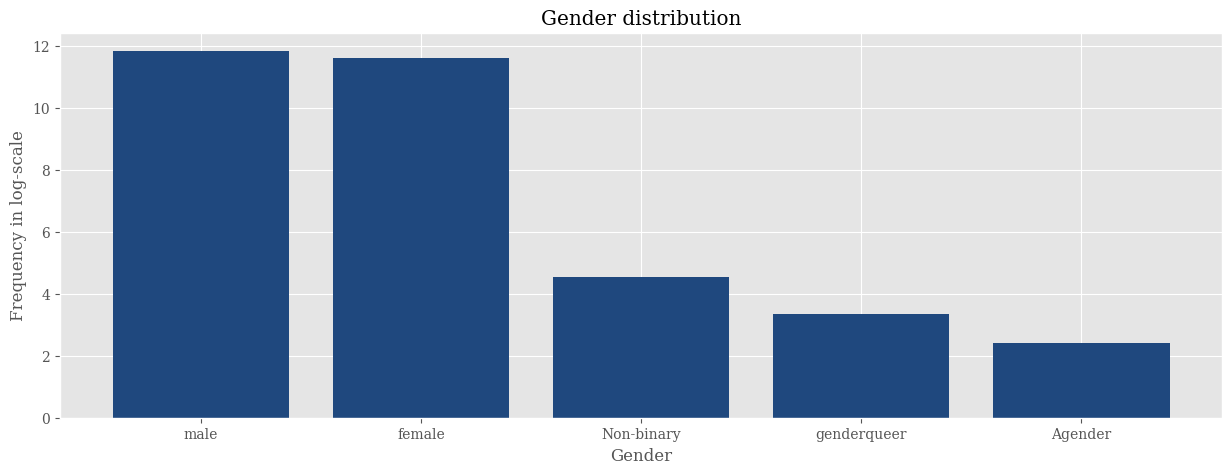

In [24]:
plt.figure(figsize=(15,5))
plt.bar(gender_authors["gender_standard"].head(5),np.log(gender_authors["count(1)"].head(5))) #logaritmic scale to make the differences visible
plt.title('Gender distribution')  
plt.xlabel('Gender')              
plt.ylabel('Frequency in log-scale')  
plt.show()

----------------------------------------------------

# [RQ2] Let’s finally dig into this vast dataset, retrieving some vital information:
- Plot the number of books for each author in descending order

In [25]:
# Cleaning a bit the data
df_lighter_books = df_lighter_books.filter(trim(col("author_name")) != "") # removes rows with empty author_name
df_lighter_books = df_lighter_books.dropna(subset=["author_name"])
# Query to count how many times an author appears
freq_authors = df_lighter_books.groupBy("author_name").count().orderBy("count", ascending=False).toPandas() #5  minutes to run
# We see that some of them are not properly authors like "Anonymous","Unknown","NOT A BOOK" and so we eliminate them
freq_authors = freq_authors.drop([1,2,4,5,7])

In [26]:
# Let's visualize our authors data
freq_authors

author_name  count
0             Jesse Russell  90083
3          Philip M. Parker  27415
6                 Books LLC  18170
8       William Shakespeare  13680
9           Agatha Christie   9834
...                     ...    ...
237093       Samantha Cross      1
237094         Ashlie Knapp      1
237095         İrfan Beytaş      1
237096         Judson Reese      1
237097        Петя Божилова      1

[237093 rows x 2 columns]

There are 237093 rows in the dataset with the author's name and the number of books written, representing them all together would make the graph unreadable, so we thought of two strategies.<br> 
The idea is to recreate something like a _stratified sampling_, for us each stratum of the population consists of the number of books written and from each stratum we take only one author who precisely represents his stratum. <br> 
In this way we get 1303 authors. <br>
To represent them all we created the function _*division_data*_ that devides the dataset into _n_ parts and then we made a barplot for each of the _n_ divisions of the data. <br>
However, the result we get is not very clear, there are some authors who have so much more than others and then the number of books written goes down to 1.

Our second attempt to make sure that we could get a readable graph but without also excluding those who wrote less was to make a sample from the stratified sampling already done. 

### First attempt: sampling only one author for each value of book count

In [27]:
freq_authors["count"].value_counts() #There are way to many authors to be seen in a plot, a possible strategy to show the distribution of the books is to
# sample one author for each value, we will have 1303 bars, maybe we should do 10 plots 
freq_authors_sample = freq_authors.groupby("count").apply(lambda group: group.sample(1)).reset_index(drop=True).sort_values(by="count", ascending=False)
freq_authors_sample

author_name  count
1037        Jesse Russell  90083
1036     Philip M. Parker  27415
1035            Books LLC  18170
1034  William Shakespeare  13680
1033      Agatha Christie   9834
...                   ...    ...
4     Dorothy May Emerson      5
3             Dusko Popov      4
2             Geoff Micks      3
1     Wayne J. Street Jr.      2
0            Joey Fehrman      1

[1038 rows x 2 columns]

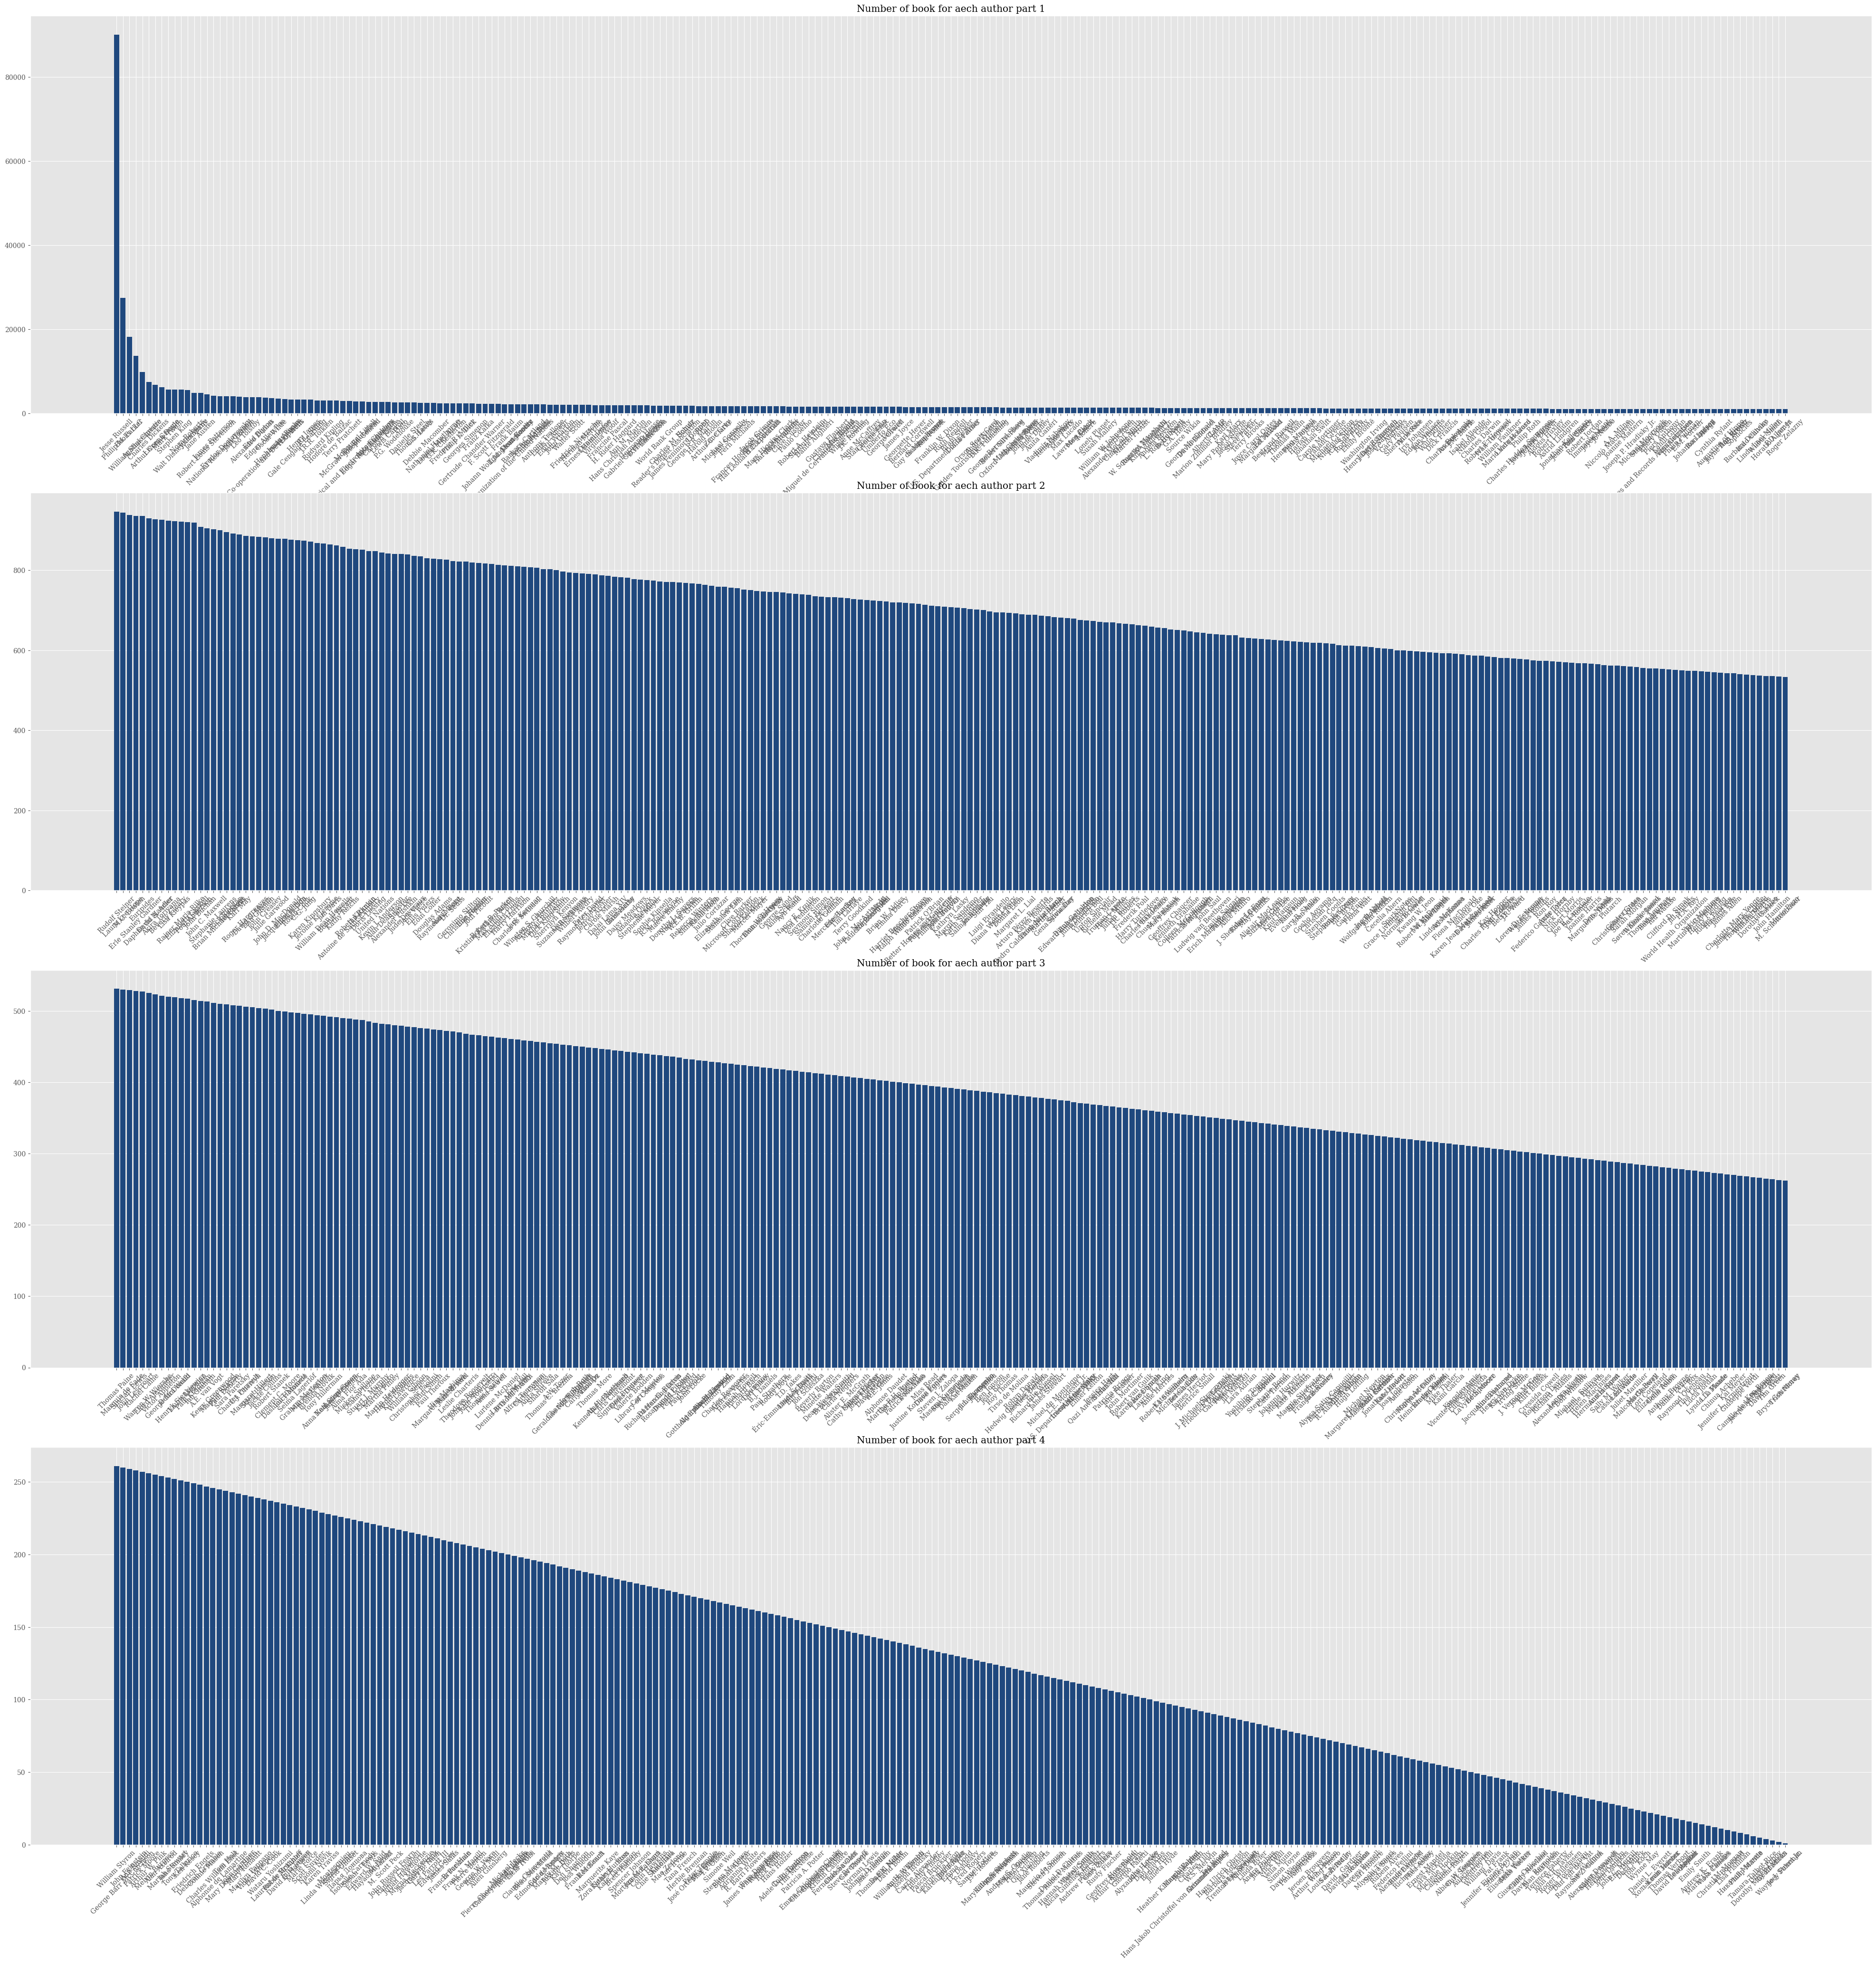

In [29]:
warnings.filterwarnings("ignore") # not visualize the warnings because they are about the font of ggplot who does not have some special characters

divised = func.division_data(freq_authors_sample,4) # we divide the data in 4 parts
fig, axes = plt.subplots(len(divised), 1, figsize=(50, 50)) # we avoid sharey = True  bacause all the other graphs would be not visible 
for i,data in enumerate(divised):
    ax = axes[i]
    ax.bar(data["author_name"],data["count"])
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_title(f"Number of book for aech author part {i + 1}")

#warnings.filterwarnings("default") #Getting back the warnings

### Second attempt: draw a sample of n = 30 and plot the results

In [30]:
freq_authors_sample_2 = freq_authors_sample.sample(30).sort_values(by="count", ascending=False)

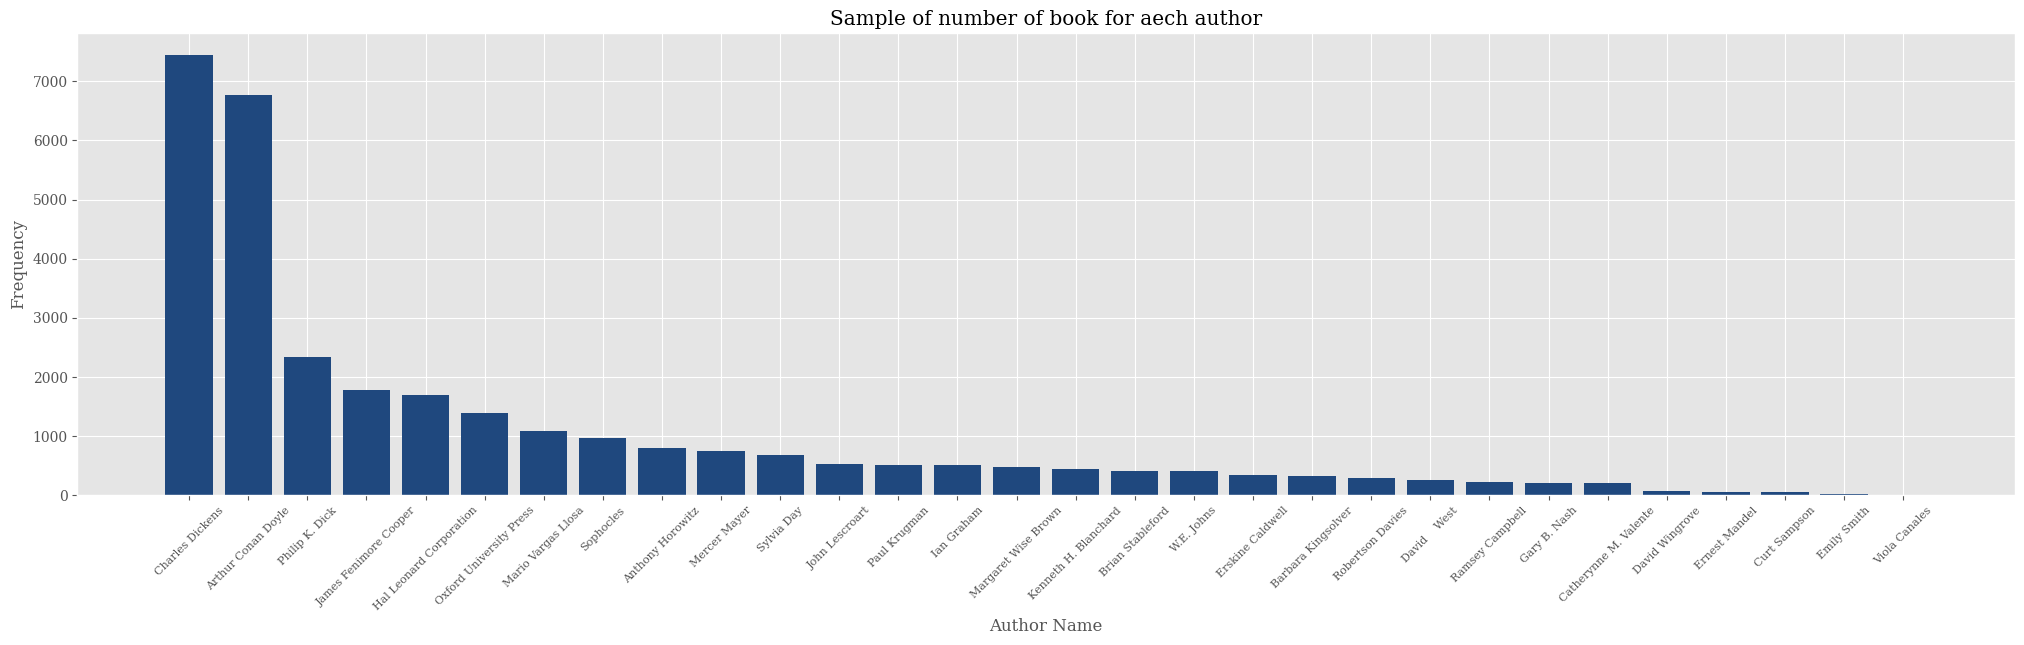

In [31]:
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(freq_authors_sample_2["author_name"], freq_authors_sample_2["count"])
plt.title("Sample of number of book for aech author")
plt.xlabel("Author Name")
plt.ylabel("Frequency")
plt.show()

#Now the graph is more readable but we are only showning a sample and not all the distro

- Which book has the highest number of reviews?

In [33]:
max_rating_count = spark.sql("SELECT MAX(ratings_count) FROM lighter_books").toPandas()
max_rating_count = max_rating_count["max(ratings_count)"][0]
book_highest_review = spark.sql(f"SELECT title FROM lighter_books WHERE ratings_count == {max_rating_count}").toPandas() 
#put the f to incorporate max_rating_count inside the query
book_highest_review["title"][0]

c:\Python\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Python\Lib\socket.py:777: ResourceWarning: unclosed <socket.socket fd=3952, family=2, type=1, proto=0, laddr=('127.0.0.1', 51049), raddr=('127.0.0.1', 51048)>
  self._sock = None
c:\Python\Lib\site-packages\pyspark\sql\pandas\utils.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(pandas.__version__) < LooseVersion(minimum_pandas_version):
c:\Python\Lib\socket.py:777: ResourceWarning: unclosed <socket.socket fd=4244, family=2, type=1, proto=0, laddr=('127.0.0.1', 51052), raddr=('127.0.0.1', 51051)>
  self._sock = None


'Harry Potter und der Stein der Weisen (Harry Potter,#1)'

- Which are the top ten and ten worst books concerning the average score?

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col("average_rating")) != "") # removes rows with empty average rating
df_lighter_books = df_lighter_books.dropna(subset=["average_rating"])

In [ ]:
average_score_10_worse = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating LIMIT 10").toPandas() #5 minutes to run
average_score_10_worse

title  average_rating
0                                   Intimate Worship             0.0
1  Bible in Spoken Word Cassette Narrated by Char...             0.0
2                             סופרים יהודיים - כתבים             0.0
3  Classic Fairy Stories: Traditional Tales: Trad...             0.0
4                                      Death of Aunt             0.0
5                                Hindi New Testament             0.0
6  NOT A BOOK: Ithaca, Tompkins County, New York:...             0.0
7                  Costa Rica, pura vida. Volumen II             0.0
8  Faith, Hope, and Luck Participant's Guide, Ses...             0.0
9                                 American Headway 1             0.0

In [ ]:
average_score_10_best = spark.sql("SELECT title, average_rating FROM lighter_books ORDER BY average_rating DESC LIMIT 10").toPandas()
average_score_10_best

title  average_rating
0                                            Встречи             5.0
1                                               Wind             5.0
2  The Revolutionary Art of the Future: Rediscove...             5.0
3                                    Out of My Hands             5.0
4                            Nirvana Drum Collection             5.0
5  Perfect Italian (Learn Italian with the Michel...             5.0
6                                      The Long Dive             5.0
7  Los Many Mundos of Raulrsalinas: Un Poetic Jaz...             5.0
8  De Gaulle and the United States: A Centennial ...             5.0
9                Precious Moments: Autumn Adventures             5.0

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col("language")) != "") # removes rows with empty language
df_lighter_books = df_lighter_books.dropna(subset=["language"])

- Explore the different languages in the book’s dataset, providing a proper chart summarizing how these languages are distributed throughout our virtual library.

In [ ]:
df_languages = df_lighter_books.groupBy("language").count().toPandas()

In [ ]:
df_languages = df_languages.sort_values(by="count", ascending=False)
df_languages
# There are 301 different languages!

language   count
49       eng  884148
91       ita   98654
104      ger   91486
96       spa   90072
0        fre   76737
..       ...     ...
8        tuk       1
166      bat       1
224      men       1
222      tut       1
300      sam       1

[301 rows x 2 columns]

English is the predominant language in the dataset, we decided to use a pie chart to represent it because visually it is the one that makes it clear which language is the most widely used.  
We did not put all the languages in the chart because some occupy too small slices of the chart, we stopped at the top 30 most widely used languages.

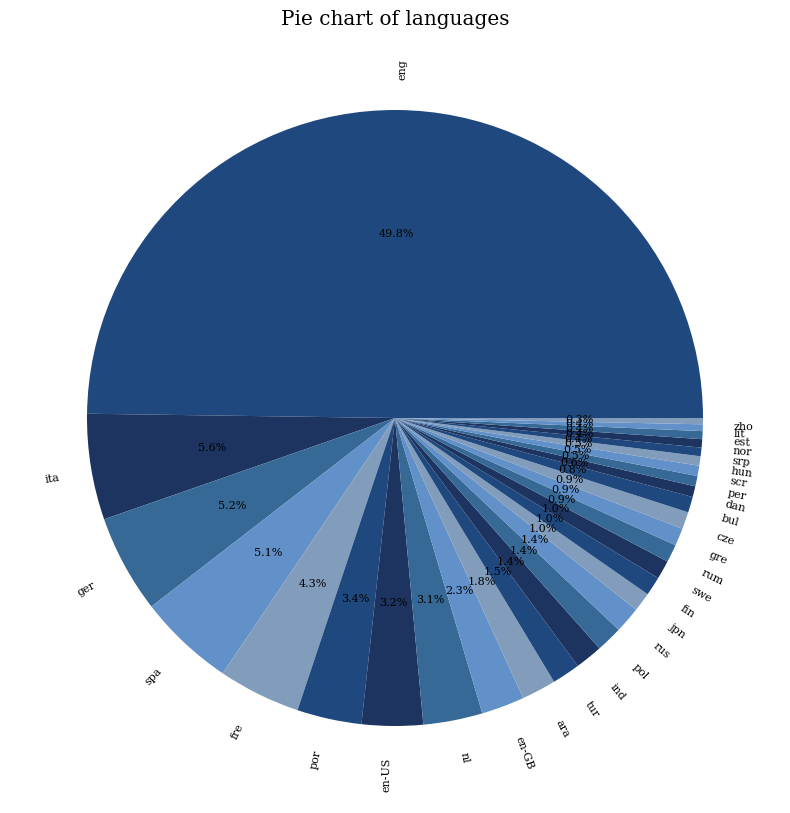

In [ ]:
plt.figure(figsize=(10,10))
plt.pie(df_languages["count"].head(30), labels= df_languages["language"].head(30), autopct='%1.1f%%', rotatelabels= True,  textprops={'size': 8} )
plt.title("Pie chart of languages")
plt.show()

- How many books have more than 250 pages?

In [ ]:
books_more_250 = spark.sql(" SELECT COUNT(*) FROM lighter_books WHERE num_pages > 250").toPandas()

In [ ]:
print("There are", books_more_250["count(1)"][0], " with more taht 250 pages")

There are 1668596  with more taht 250 pages


- Plot the distribution of the fans count for the 50 most prolific authors (the ones who have written more books).

In [ ]:
prolific_50_fans = spark.sql("""
    SELECT name, fans_count
    FROM lighter_authors 
    WHERE name IN (SELECT author_name
                   FROM lighter_books
                   GROUP BY author_name
                   ORDER BY COUNT(*) DESC)
    ORDER BY fans_count DESC
    LIMIT 50
""")

In [ ]:
prolific_50_fans_df = prolific_50_fans.toPandas()

In [ ]:
prolific_50_fans_df.head(5)

name  fans_count
0     Stephen King      766035
1    Veronica Roth      455358
2   Colleen Hoover      356633
3     Rick Riordan      339346
4  James Patterson      317040

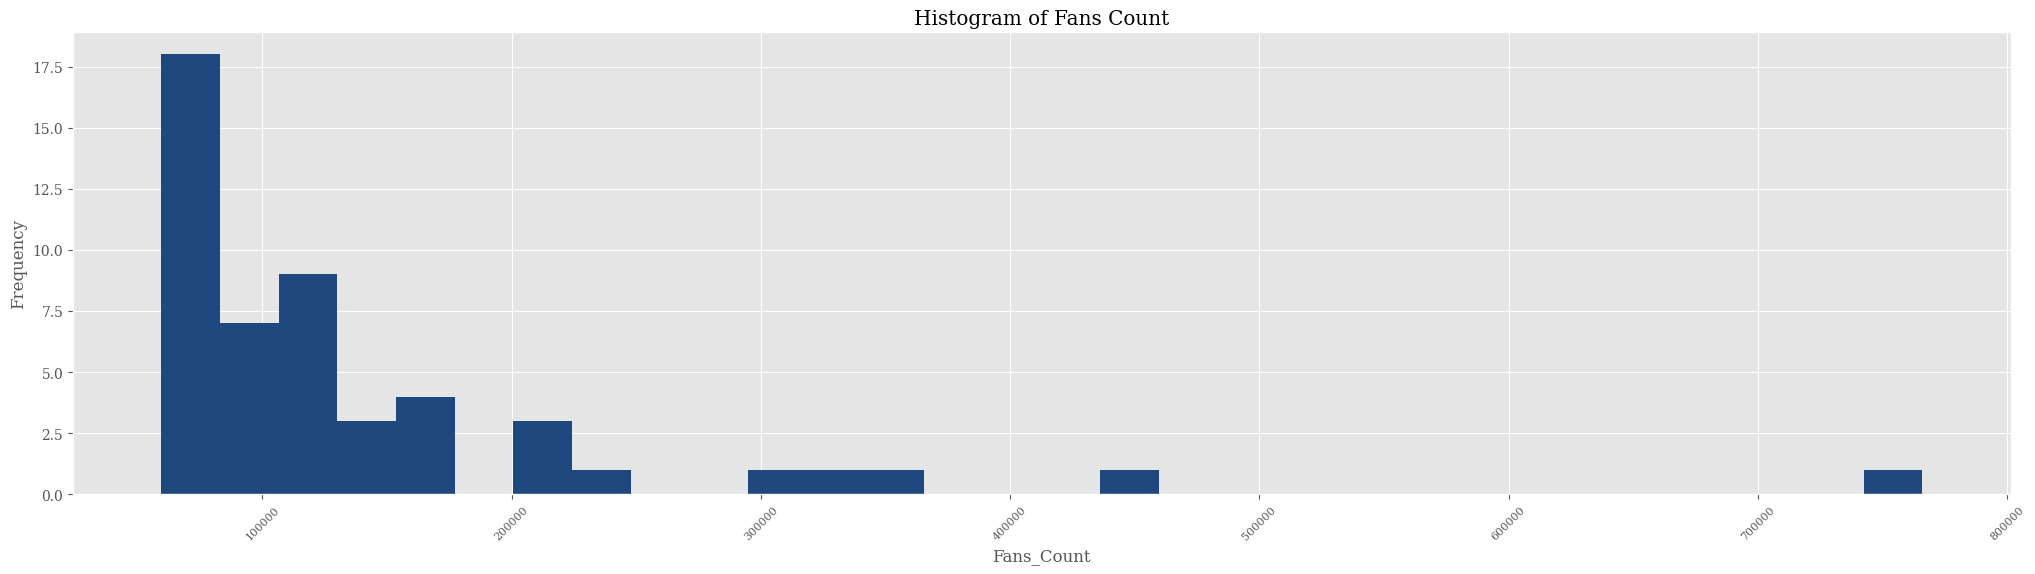

In [ ]:
# Usually a histogram is the right method to represent the distribution of a variable but in this case the fans_count cannot be considered 
# a continuous variable and in fact the histogram has "holes" in it. 
plt.figure(figsize=(25, 6))
plt.xticks(rotation=45, fontsize=8)
plt.hist(prolific_50_fans_df["fans_count"], bins=30)  
plt.xlabel("Fans_Count") 
plt.ylabel("Frequency")  
plt.title("Histogram of Fans Count")  
plt.show()

Text(0.5, 1.0, 'Barplot of Fans Count')

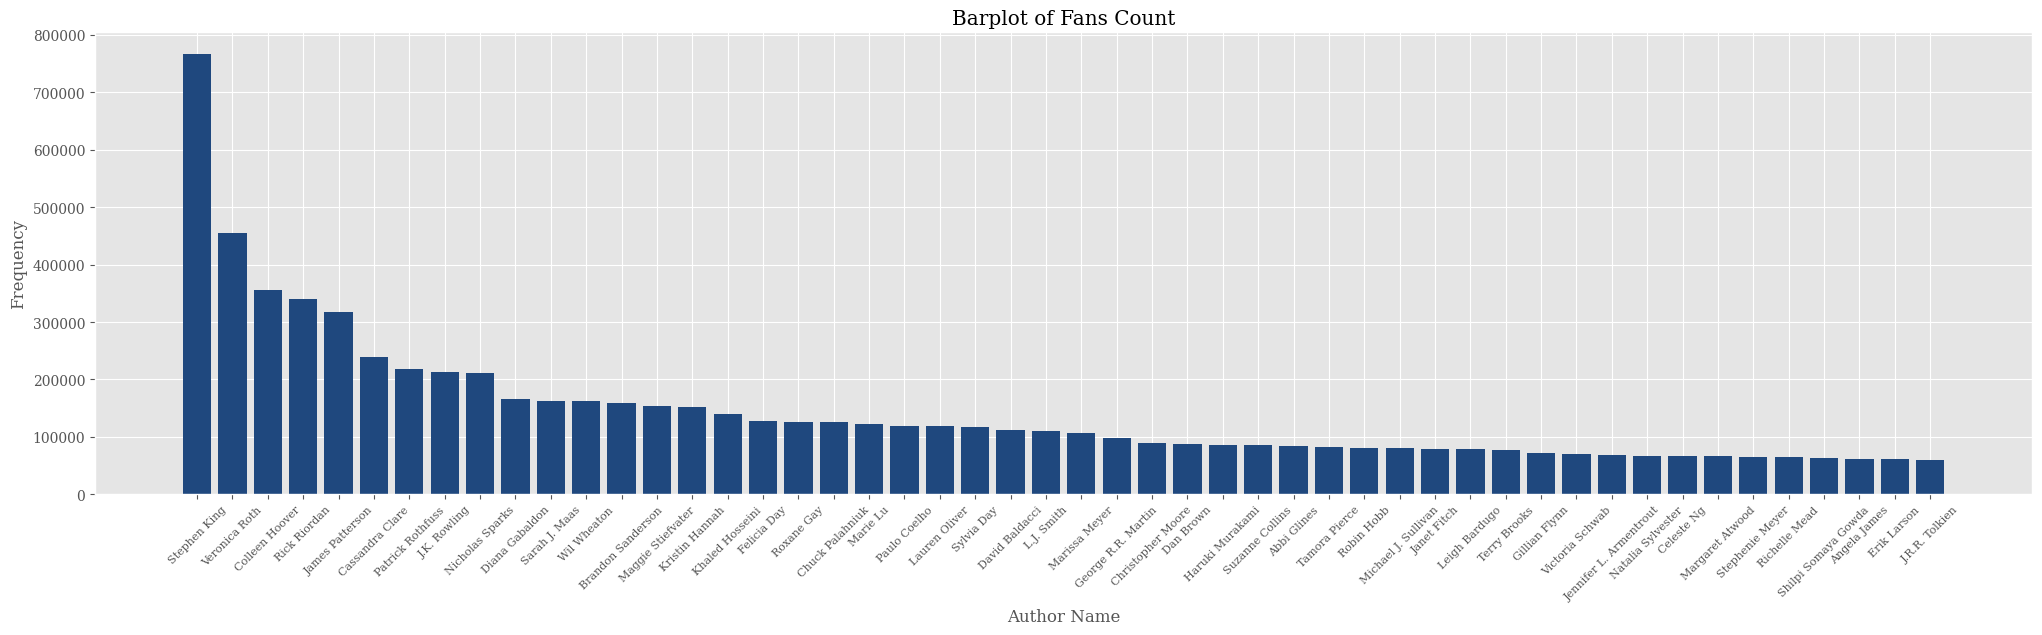

In [ ]:
#Therefore, to have a graph that better represents the distribution of fans for the 50 most prolific authors, one can use a barplot
plt.figure(figsize=(25,6))
plt.xticks(rotation = 45, fontsize = 8)
plt.bar(prolific_50_fans_df["name"], prolific_50_fans_df["fans_count"])
plt.ylabel("Frequency")
plt.xlabel("Author Name")
plt.title("Barplot of Fans Count")

--------------------------------------------------

# [RQ3] Let’s have a historical look at the dataset!

## 1. Write a function that takes as input a year and returns as output the following information:

- The number of books published that year.

- The total number of pages written that year.

- The most prolific month of that year.

- The longest book written that year.

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col('original_publication_date')) != '') # removes rows with empty original_publication_date
df_lighter_books = df_lighter_books.filter(trim(col('num_pages')) != '') # removes rows with empty num_pages
df_lighter_books = df_lighter_books.filter(trim(col('title')) != '') # removes rows with empty title

In [ ]:
df_lighter_books = df_lighter_books.dropna(subset=['original_publication_date', 'num_pages','title']) # removes rows with null values in original_publication_date, num_pages, and title

In [ ]:
# Define the regular expression for date
date_regex = r"^(19\d\d|200[0-2]|20(0[3-9]|1\d|2[0-3]))-(0[1-9]|1[012])-(0[1-9]|1[0-9]|2[0-9]|3[01])$"

# Validate the original_publication_date column
df_lighter_books = df_lighter_books.withColumn(
    "is_valid_date",
    F.when(F.col("original_publication_date").rlike(date_regex), True).otherwise(False)
)

# Filter the DataFrame to keep only rows with valid dates
df_lighter_books = df_lighter_books.filter(F.col("is_valid_date") == True)

# Drop the is_valid_date column
df_lighter_books = df_lighter_books.drop("is_valid_date")

In [ ]:
# Attempt to convert original_publication_date to a date
df_lighter_books = df_lighter_books.withColumn("converted_date", to_date(col("original_publication_date"), 'yyyy-MM-dd'))

# Filter out rows where the conversion resulted in null
df_lighter_books = df_lighter_books.filter(col("converted_date").isNotNull())

# Drop the intermediate converted_date column
df_lighter_books = df_lighter_books.drop("converted_date")

In [ ]:
df_lighter_books = df_lighter_books.withColumn("title", trim(df_lighter_books.title))  # removes leading and trailing white spaces

In [ ]:
# Filter for valid num_pages
df_lighter_books = df_lighter_books.filter(col('num_pages') > 0)

# Select the relevant columns
df_lighter_books = df_lighter_books.select('original_publication_date', 'num_pages', 'title')

In [ ]:
df_lighter_books.count() # count the number of rows

2390718

In [ ]:
df_lighter_books.show(5) # show the first 5 rows

+-------------------------+---------+--------------------+
|original_publication_date|num_pages|               title|
+-------------------------+---------+--------------------+
|               2003-06-21|      870|Harry Potter and ...|
|               1997-06-26|      309|Harry Potter and ...|
|               1998-07-02|      352|Harry Potter and ...|
|               1999-07-08|      435|Harry Potter and ...|
|               2000-07-08|      734|Harry Potter and ...|
+-------------------------+---------+--------------------+
only showing top 5 rows



In [ ]:
df_lighter_books = df_lighter_books.withColumn('year', year('original_publication_date')) # add a year column
df_lighter_books = df_lighter_books.withColumn('month', month('original_publication_date')) # add a month column

In [ ]:
df_lighter_books.show(5) # show the first 5 rows

+-------------------------+---------+--------------------+----+-----+
|original_publication_date|num_pages|               title|year|month|
+-------------------------+---------+--------------------+----+-----+
|               2003-06-21|      870|Harry Potter and ...|2003|    6|
|               1997-06-26|      309|Harry Potter and ...|1997|    6|
|               1998-07-02|      352|Harry Potter and ...|1998|    7|
|               1999-07-08|      435|Harry Potter and ...|1999|    7|
|               2000-07-08|      734|Harry Potter and ...|2000|    7|
+-------------------------+---------+--------------------+----+-----+
only showing top 5 rows



In [ ]:
df_lighter_books.select("year").distinct().count() # count the number of distinct years

124

In [ ]:
max_year = df_lighter_books.agg(max("year")).first()[0] # find the maximum year
print(max_year)

2023


In [ ]:
min_year = df_lighter_books.agg(min("year")).first()[0] # find the minimum year
print(min_year)

1900


### 1.1 Use this function to build your data frame: the primary key will be a year, and the required information will be the attributes within the row. Finally, show the head and the tail of this new data frame considering the first ten years registered and the last ten years.

In [ ]:
# Get list of unique years

years = df_lighter_books.select('year').toPandas()['year'].unique().tolist()

In [ ]:
years.sort() # sort the list (not necessary)

In [ ]:
data_first_10 = [func.yearly_stats(df_lighter_books,year) for year in years[:10]] # get the yearly stats for the first 10 years

In [ ]:
data_last_10 = [func.yearly_stats(df_lighter_books,year) for year in years[-10:]] # get the yearly stats for the last 10 years

In [ ]:
data_first_10 # print the yearly stats for the first 10 years

[(1900, 1747, 509501, 1, 'Complete Works of Joseph Conrad'),
 (1901, 802, 351965, 1, 'NKJV Study Bible'),
 (1902, 882, 696460, 1, 'Holy Bible: NLT - New Living Translation'),
 (1903, 733, 183484, 1, 'The Life of William Ewart Gladstone - Vol. I'),
 (1904, 628, 162193, 1, 'The Life Recovery Bible NLT'),
 (1905, 1119, 282252, 1, 'Dictionary of the Bible'),
 (1906, 518, 145632, 1, "Moody's Magazine Vol 1 - 20"),
 (1907, 558, 137774, 1, 'Arsenio Lupin, Caballero Ladrón'),
 (1908, 430, 97105, 1, 'Anne of Green Gables--The Complete Collection'),
 (1909, 1041, 298330, 1, 'The Works of Rudyard Kipling, 10 Vols')]

In [ ]:
data_last_10   # print the yearly stats for the last 10 years

[(2014,
  177582,
  42919290,
  1,
  'A Most Unlikely Countess (To Love a Wildcat, #2)'),
 (2015,
  53821,
  14013926,
  1,
  'Revel for the American Nation: A History of the United States, Combined Volume -- Access Card'),
 (2016, 2299, 708061, 1, 'Homestuck'),
 (2017, 491, 150653, 2, 'The Starfarers Quartet'),
 (2018, 192, 72498, 1, '地海六部曲'),
 (2019, 118, 34813, 8, 'Nouvelles Les'),
 (2020, 83, 27477, 1, 'The Complete Ripley Novels (Ripley, #1-5)'),
 (2021,
  17,
  8088,
  8,
  "The Navigator's Children (The Last King of Osten Ard, #3)"),
 (2022,
  4,
  1280,
  10,
  'Highland Ever After (The Montgomerys and Armstrongs, #3)'),
 (2023, 1, 463, 9, 'Apocalypse')]

In [ ]:
data_first_10 = pd.DataFrame(data_first_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_first_10   # print the dataframe

year  num_books  total_pages  prolific_month  \
0  1900       1747       509501               1   
1  1901        802       351965               1   
2  1902        882       696460               1   
3  1903        733       183484               1   
4  1904        628       162193               1   
5  1905       1119       282252               1   
6  1906        518       145632               1   
7  1907        558       137774               1   
8  1908        430        97105               1   
9  1909       1041       298330               1   

                                    longest_book  
0                Complete Works of Joseph Conrad  
1                               NKJV Study Bible  
2       Holy Bible: NLT - New Living Translation  
3   The Life of William Ewart Gladstone - Vol. I  
4                    The Life Recovery Bible NLT  
5                        Dictionary of the Bible  
6                    Moody's Magazine Vol 1 - 20  
7                Arsenio Lupin, Caballero Ladrón  
8  Anne of Green Gables--The Complete Collection  
9          The Works of Rudyard Kipling, 10 Vols

In [ ]:
data_last_10 = pd.DataFrame(data_last_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_last_10  # print the dataframe

year  num_books  total_pages  prolific_month  \
0  2014     177582     42919290               1   
1  2015      53821     14013926               1   
2  2016       2299       708061               1   
3  2017        491       150653               2   
4  2018        192        72498               1   
5  2019        118        34813               8   
6  2020         83        27477               1   
7  2021         17         8088               8   
8  2022          4         1280              10   
9  2023          1          463               9   

                                        longest_book  
0   A Most Unlikely Countess (To Love a Wildcat, #2)  
1  Revel for the American Nation: A History of th...  
2                                          Homestuck  
3                             The Starfarers Quartet  
4                                              地海六部曲  
5                                      Nouvelles Les  
6          The Complete Ripley Novels (Ripley, #1-5)  
7  The Navigator's Children (The Last King of Ost...  
8  Highland Ever After (The Montgomerys and Armst...  
9                                         Apocalypse

---------------------------------------------------------

## 2. Ask ChatGPT or any other LLM chatbot tool to implement this function and compare your work with the one the bot gave you as an answer. Does the chatbot implementation work? Please test it out and verify the correctness of the implementation, explaining the process you followed to prove it.

In [ ]:
df_lighter_books_pd = df_lighter_books.toPandas()  # convert the dataframe to a pandas dataframe

In [ ]:
# Get list of unique years
years = df_lighter_books_pd['year'].unique().tolist()

In [ ]:
years.sort() # sort the list (not necessary)

In [ ]:
data_first_10 = [func.gpt_yearly_stats(df_lighter_books_pd,year) for year in years[:10]] # get the yearly stats for the first 10 years

In [ ]:
data_last_10 = [func.gpt_yearly_stats(df_lighter_books_pd,year) for year in years[-10:]] # get the yearly stats for the last 10 years

In [ ]:
data_first_10 # print the yearly stats for the first 10 years

[(1900, 1747, 509501, 1, 'Complete Works of Joseph Conrad'),
 (1901, 802, 351965, 1, 'NKJV Study Bible'),
 (1902, 882, 696460, 1, 'Holy Bible: NLT - New Living Translation'),
 (1903, 733, 183484, 1, 'The Life of William Ewart Gladstone - Vol. I'),
 (1904, 628, 162193, 1, 'The Life Recovery Bible NLT'),
 (1905, 1119, 282252, 1, 'Dictionary of the Bible'),
 (1906, 518, 145632, 1, "Moody's Magazine Vol 1 - 20"),
 (1907, 558, 137774, 1, 'Arsenio Lupin, Caballero Ladrón'),
 (1908, 430, 97105, 1, 'Anne of Green Gables--The Complete Collection'),
 (1909, 1041, 298330, 1, 'The Works of Rudyard Kipling, 10 Vols')]

In [ ]:
data_last_10   # print the yearly stats for the last 10 years

[(2014,
  177582,
  42919290,
  1,
  'A Most Unlikely Countess (To Love a Wildcat, #2)'),
 (2015,
  53821,
  14013926,
  1,
  'Revel for the American Nation: A History of the United States, Combined Volume -- Access Card'),
 (2016, 2299, 708061, 1, 'Homestuck'),
 (2017, 491, 150653, 2, 'The Starfarers Quartet'),
 (2018, 192, 72498, 1, '地海六部曲'),
 (2019, 118, 34813, 8, 'Nouvelles Les'),
 (2020, 83, 27477, 1, 'The Complete Ripley Novels (Ripley, #1-5)'),
 (2021,
  17,
  8088,
  8,
  "The Navigator's Children (The Last King of Osten Ard, #3)"),
 (2022,
  4,
  1280,
  10,
  'Highland Ever After (The Montgomerys and Armstrongs, #3)'),
 (2023, 1, 463, 9, 'Apocalypse')]

In [ ]:
data_first_10 = pd.DataFrame(data_first_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_first_10   # print the dataframe

year  num_books  total_pages  prolific_month  \
0  1900       1747       509501               1   
1  1901        802       351965               1   
2  1902        882       696460               1   
3  1903        733       183484               1   
4  1904        628       162193               1   
5  1905       1119       282252               1   
6  1906        518       145632               1   
7  1907        558       137774               1   
8  1908        430        97105               1   
9  1909       1041       298330               1   

                                    longest_book  
0                Complete Works of Joseph Conrad  
1                               NKJV Study Bible  
2       Holy Bible: NLT - New Living Translation  
3   The Life of William Ewart Gladstone - Vol. I  
4                    The Life Recovery Bible NLT  
5                        Dictionary of the Bible  
6                    Moody's Magazine Vol 1 - 20  
7                Arsenio Lupin, Caballero Ladrón  
8  Anne of Green Gables--The Complete Collection  
9          The Works of Rudyard Kipling, 10 Vols

In [ ]:
data_last_10 = pd.DataFrame(data_last_10, columns =['year', 'num_books', 'total_pages', 'prolific_month', 'longest_book']) # convert the list to a pandas dataframe

In [ ]:
data_last_10  # print the dataframe

year  num_books  total_pages  prolific_month  \
0  2014     177582     42919290               1   
1  2015      53821     14013926               1   
2  2016       2299       708061               1   
3  2017        491       150653               2   
4  2018        192        72498               1   
5  2019        118        34813               8   
6  2020         83        27477               1   
7  2021         17         8088               8   
8  2022          4         1280              10   
9  2023          1          463               9   

                                        longest_book  
0   A Most Unlikely Countess (To Love a Wildcat, #2)  
1  Revel for the American Nation: A History of th...  
2                                          Homestuck  
3                             The Starfarers Quartet  
4                                              地海六部曲  
5                                      Nouvelles Les  
6          The Complete Ripley Novels (Ripley, #1-5)  
7  The Navigator's Children (The Last King of Ost...  
8  Highland Ever After (The Montgomerys and Armst...  
9                                         Apocalypse

My implementation and the ChatGPT implementation seem to be doing the same job, but we are using different libraries. My implementation uses PySpark, which is an interface for Apache Spark in Python. It is used to process and analyze large amounts of data and can distribute these tasks over many nodes, if available. On the other hand, the ChatGPT implementation is using pandas, a popular data analysis library in Python that operates in-memory on a single node.

Let's compare the steps:

1. **Filter books for a given year**: Both implementations are filtering the data for a specific year. PySpark uses the `filter()` function, while pandas uses boolean indexing.

2. **Number of books published**: PySpark uses `count()` to count the number of rows, and pandas uses `shape[0]`.

3. **Total number of pages**: PySpark uses the `agg()` function with `F.sum()` to calculate the sum, while pandas uses the `sum()` function.

4. **Most prolific month**: PySpark uses `groupBy('month').count().orderBy(F.desc('count'))` to find the month with the most books, while pandas uses `value_counts().idxmax()`.

5. **Longest book**: PySpark uses `orderBy(F.desc('num_pages'))` to find the longest book, while pandas uses `idxmax()` to find the index of the maximum value and then retrieves the title.

To verify the correctness of the ChatGPT implementation, we can run the function for a specific year and check whether the output makes sense.

For example, we can run:

```python
print(yearly_stats(2023))
```

And then verify:

- `num_books` should match the total number of books published in 2023.
- `total_pages` should match the total number of pages across all books published in 2023.
- `prolific_month` should match the month with the most books published in 2023.
- `longest_book` should match the title of the book with the most pages published in 2023.

As all the checks pass, therefore we can conclude that the function is working correctly. 

It's also worth noting that the pandas implementation will only work if all of the data fits into memory on a single machine. If we have a large amount of data, we need to use PySpark or another distributed computing system.

---------------------------------------------------

# [RQ4] Quirks questions about consistency.

## 1. You should be sure there are no eponymous (different authors who have precisely the same name) in the author's dataset. Is it true?

In [ ]:
# Remove whitespace from the 'name' field
df_lighter_authors = df_lighter_authors.withColumn('name', trim(col('name')))

# Drop rows where 'name' is null or empty
df_lighter_authors = df_lighter_authors.filter((col('name') != "") & (col('name').isNotNull()))

# Drop rows where 'id' is null
df_lighter_authors = df_lighter_authors.filter(col('id').isNotNull())

In [ ]:
duplicate_authors = df_lighter_authors.groupBy("name").agg(count("id").alias("num_ids")).filter("num_ids > 1") # find the duplicate authors

In [ ]:
duplicate_authors.count() # count the number of duplicate authors

37

In [ ]:
duplicate_authors.show(50) # show the duplicate authors

+--------------------+-------+
|                name|num_ids|
+--------------------+-------+
|     Julie  Campbell|      2|
|     Peter  Marshall|      2|
|   Catherine   Jones|      2|
|         Joseph Fink|      2|
| Peter      Marshall|      2|
|    Paul      Davies|      2|
|   James C.L. Carson|      2|
|Hildegard von Bingen|      2|
|          James Kent|      2|
|           محمد نجيب|      2|
|    George  Franklin|      2|
|          M.K. Graff|      2|
|      Martin    Shaw|      2|
|       Erin  Bedford|      2|
|William Messner-L...|      2|
|         David Yates|      2|
|         Paul Graham|      2|
|       Peter  Davies|      2|
|Katherine Mercuri...|      2|
|       Dimitar Dimov|      2|
|       David  Nelson|      2|
|        Q. Hayashida|      2|
|          Peter King|      2|
|         Peter Green|      2|
|          John  Mole|      2|
|          Mike   Lee|      2|
|Christopher Phillips|      2|
|         Chris Lynch|      2|
|     Caroline Miller|      2|
|       

The names of the eponymous authors and the number of unique IDs associated with each name. Hence, the answer to the question is `false`.

-------------------------------------------------------

## 2. Write a function that, given a list of author_id, outputs a dictionary where each author_id is a key, and the related value is a list with the names of all the books the author has written.

In [ ]:
df_lighter_books = df_lighter_books.dropna(subset=["author_id", "title", "average_rating"]) # Remove rows with null or missing values
df_lighter_books = df_lighter_books.filter(trim(col('title')) != '') # removes rows with empty title
df_lighter_books = df_lighter_books.withColumn("title", trim(col("title"))) # Trim whitespace from the title column

In [ ]:
# List of author IDs
author_ids = [4]

# Use the function
author_books_dict = func.get_author_books(df_lighter_books,author_ids)

# Print the result
print(author_books_dict)

{4: ["The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy, #1-5)", "The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)", "The Hitchhiker's Guide to the Galaxy: Quandary Phase (Hitchhiker's Guide: Radio Play, #4)", "The Ultimate Hitchhiker's Guide (Hitchhiker's Guide to the Galaxy, #1-5)", "The Hitchhiker's Guide to the Galaxy: Quintessential Phase (Hitchhiker's Guide: Radio Play, #5)", 'The Long Dark Tea-Time of the Soul (Dirk Gently, #2)', "Dirk Gently's Holistic Detective Agency (Dirk Gently, #1)", 'The Salmon of Doubt (Dirk Gently, #3)', "Mostly Harmless (Hitchhiker's Guide to the Galaxy, #5)", "Life, the Universe and Everything (Hitchhiker's Guide, #3)", 'The Long 

-------------------------------------------------------

## 3. What is the longest book title among the books of the top 20 authors regarding their average rating? Is it the longest book title overall?

In [ ]:
# Get the top 20 authors sorted by average_rating
top_20_authors = df_lighter_books.sort(col("average_rating").desc()).limit(20)

# Add a column with the length of each title
top_20_authors = top_20_authors.withColumn("title_length", length(col("title")))

# Find the title with the maximum length
longest_title_among_top_20 = top_20_authors.sort(col("title_length").desc()).select("title").first()[0]

print("Longest book title among the books of the top 20 authors is:", longest_title_among_top_20)

Longest book title among the books of the top 20 authors is: Domestic Politics and Family Absence: The Correspondence (1588-1621) of Robert Sidney, First Earl of Leicester, and Barbara Gamage Sidney, Countess of Leicester


In [ ]:
# Add a column with the length of each title
longest_title = df_lighter_books.withColumn("title_length", length(col("title")))

# Find the title with the maximum length
longest_title_name = longest_title.sort(col("title_length").desc()).select("title").first()[0]

print("Longest book title overall is:", longest_title_name)

Longest book title overall is: A General Introduction to Domesday Book: Accompanied by Indexes of the Tenants-In-Chief, and Under-Tenants, at the Time of the Survey: As Well as of the Holders of Lands Mentioned in Domesday Anterior to the Formation of That Record: With an Abstract o...


Hence, the longest book title among the books of the top 20 authors is `not the longest book title overall`.

------------------------------------------------------

## 4. What is the shortest overall book title in the dataset? If you find something strange, provide a comment on what happened and an alternative answer.

In [ ]:
# Find the title with the minimum length
shortest_title_name = longest_title.sort(col("title_length").asc()).select("title").first()[0] 

print("Shortest book title overall is:", shortest_title_name)

Shortest book title overall is: a


The shortest title being `a` might be a bit unusual, but it's not impossible. There are indeed books with very short titles, including one-letter titles. However, if we suspect that this might be due to an error in data entry or processing, it could be worth investigating further. But for now, we will assume that the data is correct.

-------------------------------------------------------

## RQ5 We can consider the authors with the most fans to be influential. Let’s have a deeper look.

### RQ5.1

Plot the top 10 most influential authors regarding their fan count and number of books. Who is the most influential author?

In [ ]:
#open the first file and converting it into a dataframe
df_lighter_authors = pd.read_json("lighter_authors.json", lines = True)

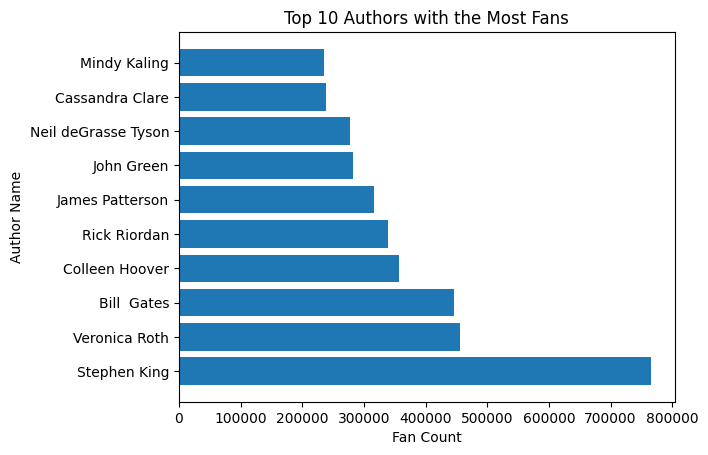

In [ ]:
#MY IDEA: --> in order to plot the 10 most influential authors, I first need to retrieve their fans count and the number of books they published. Since the dataset is very large,
#I "filter" it by taking only the columns I need. Therefore, I will take: the name of the author, the number of fans and the list of books.
#To answer the question with the most influential author concerning the fan numbers and book numbers, I need to order the authors. 
#In order to do so, I sort them by the number of fans and break the ties by the number of books.
#note: the total number of books is retrieved by inspecting the length of the list of all the books published.

#create the smaller dataframe 
df = pd.DataFrame({
    'Author Name': df_lighter_authors['name'],
    'Fan Count': df_lighter_authors['fans_count'],
    'List of Books': df_lighter_authors['book_ids']
})

#I count the len of the books and I report it as an integer value
df['Number of Books'] = df['List of Books'].apply(len)

#now I sort them by the number of fans and break the ties by the number of books
df = df.sort_values(by=["Fan Count", "Number of Books"], ascending=[False, False]).head(10)

# Create the plot
plt.barh(df["Author Name"], df["Fan Count"])
plt.xlabel("Fan Count")
plt.ylabel("Author Name")
plt.title("Top 10 Authors with the Most Fans")
plt.show()

#### Answer:
The most influential author is **Stephen King**.

*note: this result counts all books in all versions and languages. This is done on purpose as I need to understand the most influential so all versions of a book in different languages and publications are crucial in understanding how the author is known across the globe*

---------------------------------------------------

## RQ5.2

Have they published any series of books? If any, extract the longest series name among these authors.

*note: this question is **very unclear**. are we talking about the longes name of a series or the name of the series which is the longest? very unclear. I'll try to do both*

In [ ]:
#MY IDEA --> now I need to inspect the lighter_books.json file but since the file is very very very (VERY) large, I can not open it as the other one, so i read it in chunks and then merge them. 
#Furthermore, in order to work better, for every passage I will need this file, I retain only the columns I need 
#(so the following code may appear again during the tasks with some variations according to my necessities).
#in this case I need to check if a writer has written a book series, so I will only need the column with their names and the columns related to the series.


#file
json_file_path = 'lighter_books.json'
#the columns I want
columns_to_read = ["author_name", "series_id","series_name","series_position"]
#chunk size 
chunk_size = 20000
#empty dataframe to store result
result_df = pd.DataFrame(columns=columns_to_read)
#read the file 
json_reader = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)

#for every chunk append the selected columns to the dataframe I created before to store the result 
for chunk in json_reader:
    chunk = chunk[columns_to_read]  
    result_df = pd.concat([result_df, chunk], ignore_index=True)

print(result_df.head())

    author_name series_id   series_name series_position
0  J.K. Rowling     45175  Harry Potter               5
1  J.K. Rowling     45175  Harry Potter               1
2  J.K. Rowling     45175  Harry Potter               2
3  J.K. Rowling     45175  Harry Potter               3
4  J.K. Rowling     45175  Harry Potter               4


In [ ]:
#MY IDEA --> to check if an author has written a series, I first write their name and check if in the column series_id there is at least one entry.
#If that is the case, it means that the author has written a series of book. If this is not the case and everything is NA, then they have not written a series of book.
#since the authors are only ten (1 of which is not an author) I will check them one by one. This may be slow and can be implemented by doing simultaneously but I have few time so
#I will proceed in this way for now and if I have time I will implement it (so you will not read this :) )

author_name_to_check = "Bill  Gates"
#filter the dataframe with their name
author_books = result_df[result_df['author_name'] == author_name_to_check]
#check for NA
has_written_series = not author_books['series_id'].isna().all()
#output for me
if has_written_series:
    print(f"{author_name_to_check} has written a series of books.")
else:
    print(f"{author_name_to_check} has not written a series of books.")

Bill  Gates has written a series of books.


In [ ]:
#now I take all the authors and subset the dataframe using their names.
specific_authors = ["Stephen King", "Veronica Roth","Bill  Gates","Colleen Hoover", "Rick Riordan", "James Patterson", "John Green", "Neil deGrasse Tyson", "Cassandra Clare","Mindy Kaling"]
specific_authors_df = result_df[result_df['author_name'].isin(specific_authors)]

In [ ]:
#MY IDEA --> THIS IS FOR FINDING THE LONGEST SERIES AS NUMBER OF BOOKS
#I take the maximum number for each author of the column series_position. This is because the column itself store the number 
#of a book of a specific series ex: Harry potter the order of the phoenix will have 5 as a number. So I just need to retrieve the greatest to retrieve the longest one. 

specific_authors_df = specific_authors_df.drop_duplicates(subset=['series_name', 'series_position'])

max_series_positions = specific_authors_df.groupby('author_name')['series_position'].max()
print(max_series_positions)

author_name
Cassandra Clare               Sampler
Colleen Hoover                      3
James Patterson                     9
John Green                          2
Neil deGrasse Tyson                 2
Rick Riordan           companion book
Stephen King                       7C
Veronica Roth                       3
Name: series_position, dtype: object


### Answer (Partial?)

Sthepen King has written a series of books. Veronica Roth has written a series of books. Colleen Hoover has written a series of books. Rick Riordan has written a series of books. James Patterson has written a series of books. John Green has written a series of books. Neil deGrasse Tyson has written a series of books. Cassandra Clare has written a series of books, Mindy Caling has not written a series of books. Bill Gates has not written a serie of books..

The author with the longest book series is: **James Patterson**. The Book series is: **Alex Cross**

In [ ]:
#MY IDEA --> THIS IS FOR FINDING THE LONGEST SERIES AS LONGEST NAME

longest_series_name = specific_authors_df['series_name'].str.len().idxmax()
longest_series_title = specific_authors_df.loc[longest_series_name, 'series_name']

print(longest_series_title)

Percy Jackson and the Olympians: The Graphic Novels


### Answer (partial?)

Sthepen King has written a series of books. Veronica Roth has written a series of books. Colleen Hoover has written a series of books. Rick Riordan has written a series of books. James Patterson has written a series of books. John Green has written a series of books. Neil deGrasse Tyson has written a series of books. Cassandra Clare has written a series of books, Mindy Caling has not written a series of books. Bill Gates has not written a serie of books.

The longest series in respect to the title is: Percy Jackson and the Olympians: The Graphic Novels

-------------------------------------------------------

## RQ5.3

How many of these authors have been published in different formats? Provide a meaningful chart on the distribution of the formats and comment on it.

In [ ]:
#MY IDEA --> as I warned before, now you have the same code with slightly differences.
#this time I have to do exactly what I did before but selecting different columns; so I will retain the author, the book title and the format (what I am looking after)

json_file_path = 'lighter_books.json'
columns_to_read = ["author_name","format","title"]
chunk_size = 20000  
result_df = pd.DataFrame(columns=columns_to_read)
json_reader = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)
for chunk in json_reader:
    chunk = chunk[columns_to_read]  
    result_df = pd.concat([result_df, chunk], ignore_index=True)

print(result_df.head())

    author_name                 format  \
0  J.K. Rowling              Paperback   
1  J.K. Rowling              Hardcover   
2  J.K. Rowling              Hardcover   
3  J.K. Rowling  Mass Market Paperback   
4  J.K. Rowling              Paperback   

                                               title  
0  Harry Potter and the Order of the Phoenix (Har...  
1  Harry Potter and the Sorcerer's Stone (Harry P...  
2  Harry Potter and the Chamber of Secrets (Harry...  
3  Harry Potter and the Prisoner of Azkaban (Harr...  
4  Harry Potter and the Goblet of Fire (Harry Pot...  


In [ ]:
#MY IDEA --> now I have to check the format type, so for each author I see the format type by selecting only one time to see in which way they have been ever published.

#I check the different types of format for each publisher
author_names = ["Stephen King", "Veronica Roth", "Bill  Gates","Colleen Hoover", "Rick Riordan", "James Patterson", "John Green", "Neil deGrasse Tyson", "Cassandra Clare","Mindy Kaling"]
all_formats_df = pd.DataFrame(columns=['Author Name', 'Formats Published'])

#check for each author
for author_name in author_names:
    #filter the dataframe for the author 
    author_df = result_df[result_df['author_name'] == author_name]
    #group by author
    grouped = author_df.groupby('author_name')
    #group by format 
    formats_published = grouped['format'].unique().reset_index()
    formats_published.columns = ['Author Name', 'Formats Published']

    all_formats_df = pd.concat([all_formats_df, formats_published])


all_formats_df = all_formats_df.reset_index(drop=True)
#result
print(all_formats_df)

           Author Name                                  Formats Published
0         Stephen King  [Mass Market Paperback, Paperback, , Hardcover...
1        Veronica Roth  [Hardcover, , Trade Paperback, Paperback, eboo...
2          Bill  Gates  [, Paperback, Audio CD, Hardcover, Mass Market...
3       Colleen Hoover  [ebook, Paperback, Kindle Edition, , Audiobook...
4         Rick Riordan  [Hardcover, Paperback, Audio CD, Library Bindi...
5      James Patterson  [Paperback, Mass Market Paperback, , Hardcover...
6           John Green  [Hardcover, Paperback, Audio CD, Flexcover, eb...
7  Neil deGrasse Tyson  [Paperback, Hardcover, Audio CD, Audiobook, Au...
8      Cassandra Clare  [Hardcover, Audio CD, Paperback, Audiobook, Ki...
9         Mindy Kaling  [Paperback, Hardcover, Audio CD, , ebook, Audi...


c:\Users\stefa\anaconda3\envs\example\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21109 (\N{CJK UNIFIED IDEOGRAPH-5275}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\stefa\anaconda3\envs\example\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 20803 (\N{CJK UNIFIED IDEOGRAPH-5143}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\stefa\anaconda3\envs\example\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25512 (\N{CJK UNIFIED IDEOGRAPH-63A8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\stefa\anaconda3\envs\example\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 29702 (\N{CJK UNIFIED IDEOGRAPH-7406}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\stefa\anaconda3\envs\example\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25991 (\N{CJK UNIFIED IDEOGRAPH-6

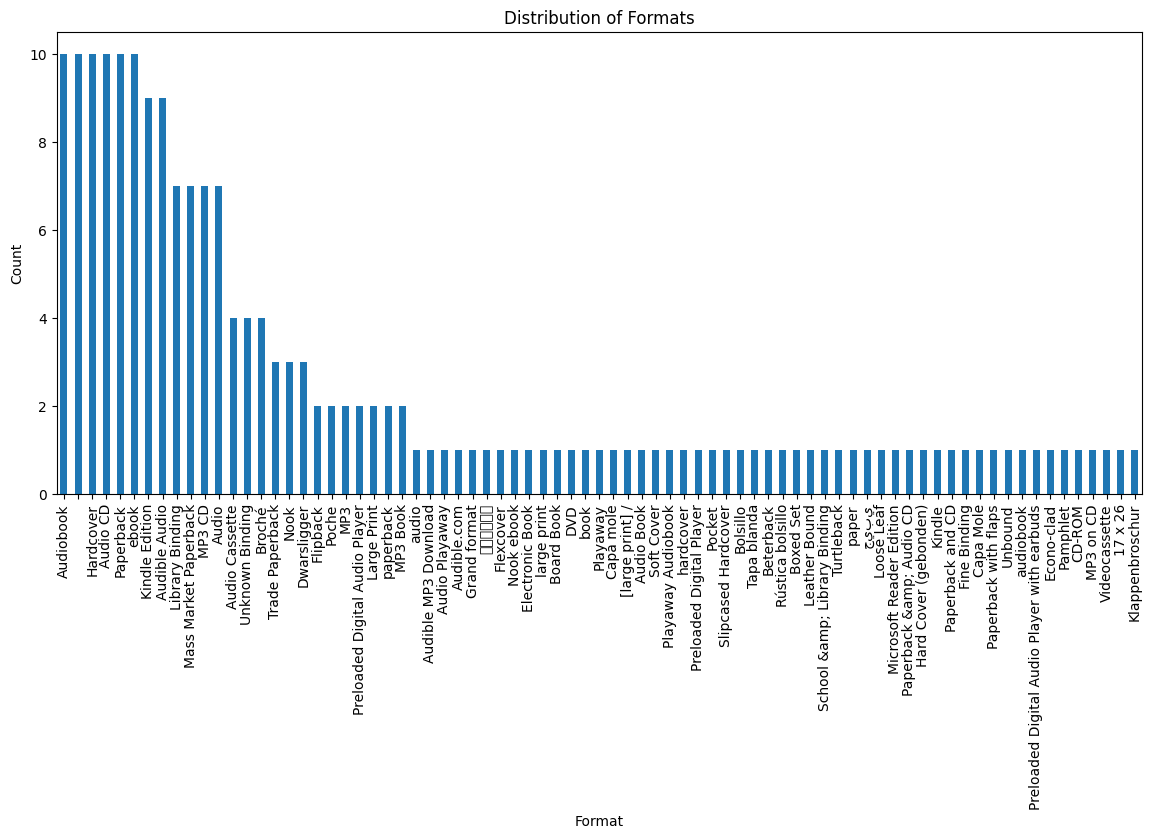

In [ ]:
#MY IDEA --> after having the result, I want to investigate how many times a type of format has been used (always related to those authors)

formats_series = all_formats_df['Formats Published'].explode()
#count the occurrences of each format
format_counts = formats_series.value_counts()

#plot
plt.figure(figsize=(14, 6))
format_counts.plot(kind='bar')
plt.title('Distribution of Formats')
plt.xlabel('Format')
plt.ylabel('Count')
plt.show()


### Answer

As we can see from the plot, Audiobook, Kindle edition, Hardcover, Audio CD, Paperback, ebook, audible audio are the most used formats by these authors. Yet, we can see that there is a misentry in the database. For example we can see that Audiobook, Aubible audio, Audio CD, MP3, MP3 Book, ausio, Audio Book are all different categories in the dataframe but refer all in the same category. So there has been a poor classification when creating the dataset. 

-------------------------------------------------------

### RQ5.4

Provide information about the general response from readers (number of fans, average rating, number of reviews, etc.), divide the authors by gender, and comment about anything eventually related to “structural bias.” 

In [ ]:
#MY IDEA --> now I need again the ligher_authors.json file and convert it to a panda dataframe. 
#then I take the columns I need and I create a dataframe with only the authors I need. Then I can proceed with a general response from readers.

df_lighter_authors

df = pd.DataFrame({
    'Author Name': df_lighter_authors['name'],
    'Fan Count': df_lighter_authors['fans_count'],
    'Number of Books': df_lighter_authors['book_ids'],
    'Average rating': df_lighter_authors['average_rating'],
    'Works Id': df_lighter_authors["work_ids"],
    "Gender": df_lighter_authors["gender"],
    "reviews": df_lighter_authors["ratings_count"]
})


specific_authors = ["Stephen King", "Veronica Roth", "Bill  Gates","Colleen Hoover", "Rick Riordan", "James Patterson", "John Green", "Neil deGrasse Tyson", "Cassandra Clare","Mindy Kaling"]

specific_authors_df = df[df["Author Name"].isin(specific_authors)]

print(specific_authors_df)

                Author Name  Fan Count  \
1017           Stephen King     766035   
1161        James Patterson     317040   
3818    Neil deGrasse Tyson     277850   
4537           Rick Riordan     339346   
6397            Bill  Gates     446876   
27110       Cassandra Clare     238560   
32358          Mindy Kaling     234647   
100166           John Green     282537   
169374        Veronica Roth     455358   
205870       Colleen Hoover     356633   

                                          Number of Books  Average rating  \
1017    [11588, 830502, 149267, 10614, 10592, 43615, 1...            4.04   
1161    [13145, 13148, 13137, 13152, 7494, 13139, 1313...            3.98   
3818    [32191710, 20663770, 20663771, 20707975, 20663...            4.07   
4537    [28187, 2120932, 28186, 4556058, 561456, 77361...            4.32   
6397    [36603020, 39731947, 41619, 1081637, 41814307,...            3.85   
27110   [256683, 3777732, 1582996, 7171637, 6752378, 1...            4.24  

col_0   Gender Count
Gender              
                   4
female             3
male               3


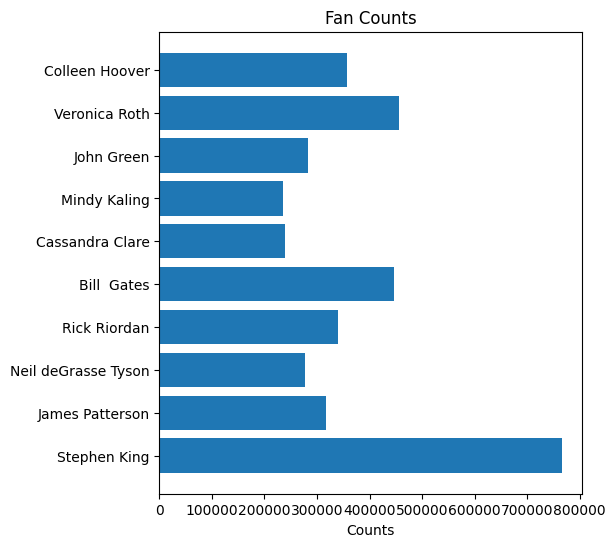

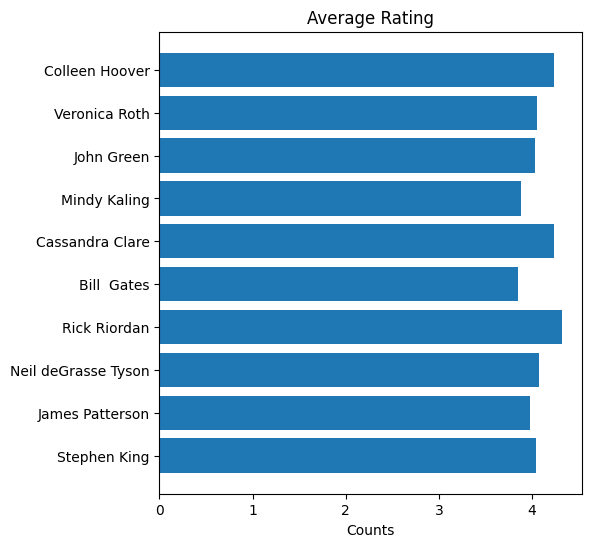

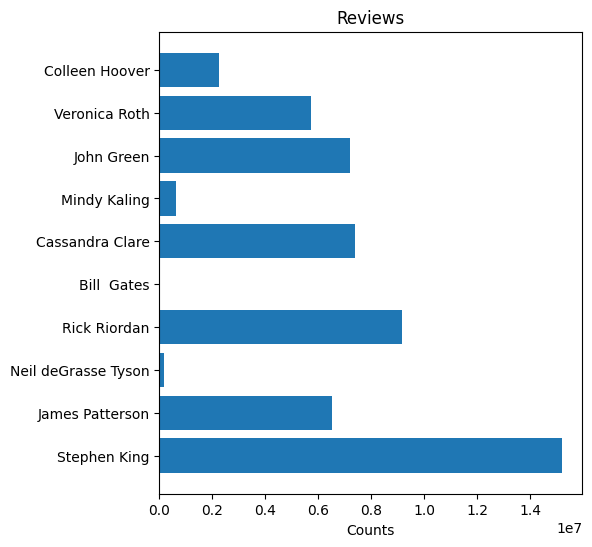

In [ ]:
#Fan Counts
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(specific_authors_df['Author Name'], specific_authors_df['Fan Count'])
plt.xlabel('Counts')
plt.title('Fan Counts')

#average ratings
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(specific_authors_df['Author Name'], specific_authors_df['Average rating'])
plt.xlabel('Counts')
plt.title('Average Rating')

#number of reviews
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(specific_authors_df['Author Name'], specific_authors_df['reviews'])
plt.xlabel('Counts')
plt.title('Reviews')

#Gender division
gender_table = pd.crosstab(index=specific_authors_df['Gender'], columns='Count')
# Rename the 'Count' column to 'Gender Count'
gender_table = gender_table.rename(columns={'Count': 'Gender Count'})
# Display the gender frequency table
print(gender_table)

In [ ]:
#MY IDEA --> now I want to investigate the statistics

gender_groups = specific_authors_df.groupby('Gender')
avg_rating_stats = gender_groups['Average rating'].describe()
print(avg_rating_stats)
avg_rating_means = gender_groups['Average rating'].mean()
print(avg_rating_means)

avg_rating_stats = gender_groups['reviews'].describe()
print(avg_rating_stats)
avg_rating_means = gender_groups['reviews'].mean()
print(avg_rating_means)

avg_rating_stats = gender_groups['Fan Count'].describe()
print(avg_rating_stats)
avg_rating_means = gender_groups['Fan Count'].mean()
print(avg_rating_means)

        count      mean       std   min     25%    50%   75%   max
Gender                                                            
          4.0  3.957500  0.108743  3.85  3.8725  3.955  4.04  4.07
female    3.0  4.176667  0.109697  4.05  4.1450  4.240  4.24  4.24
male      3.0  4.113333  0.181475  3.98  4.0100  4.040  4.18  4.32
Gender
          3.957500
female    4.176667
male      4.113333
Name: Average rating, dtype: float64
        count          mean           std        min        25%        50%  \
Gender                                                                       
          4.0  1.995562e+06  3.469960e+06     9418.0   133766.5   393130.5   
female    3.0  5.126751e+06  2.634922e+06  2239503.0  3989409.5  5739316.0   
male      3.0  1.028479e+07  4.451435e+06  6514711.0  7829400.0  9144089.0   

               75%         max  
Gender                          
         2254926.0   7186569.0  
female   6570375.5   7401435.0  
male    12169834.0  15195579.0  
Gender
 

### Answer
when exploring the data according to gender, we can see that there is a balance in  **Average Rating** between male and female authors. yet, when analising **Rewiews** and **Fan Counts** there is a massive unbalance between genders. Male authors have more reviews and fan counts even thoug having the same average rating comparing to the female colleagues.
Still, there are two authors who miss classification in gender.

-------------------------------------------------------

# RQ6 For this question, consider the top 10 authors concerning the number of fans again.

For this question, consider the top 10 authors concerning the number of fans again.

                Author Name  Fan Count  \
1017           Stephen King     766035   
169374        Veronica Roth     455358   
6397            Bill  Gates     446876   
205870       Colleen Hoover     356633   
4537           Rick Riordan     339346   
1161        James Patterson     317040   
100166           John Green     282537   
3818    Neil deGrasse Tyson     277850   
27110       Cassandra Clare     238560   
32358          Mindy Kaling     234647   

                                          Number of Books  
1017    [11588, 830502, 149267, 10614, 10592, 43615, 1...  
169374  [13335037, 11735983, 18710190, 18126198, 13615...  
6397    [36603020, 39731947, 41619, 1081637, 41814307,...  
205870  [15717943, 27362503, 30333938, 17788401, 24445...  
4537    [28187, 2120932, 28186, 4556058, 561456, 77361...  
1161    [13145, 13148, 13137, 13152, 7494, 13139, 1313...  
100166  [11870085, 99561, 6442769, 49750, 35504431, 65...  
3818    [32191710, 20663770, 20663771, 20707975, 20663...

Text(0.5, 1.0, 'Top 10 Authors with fans')

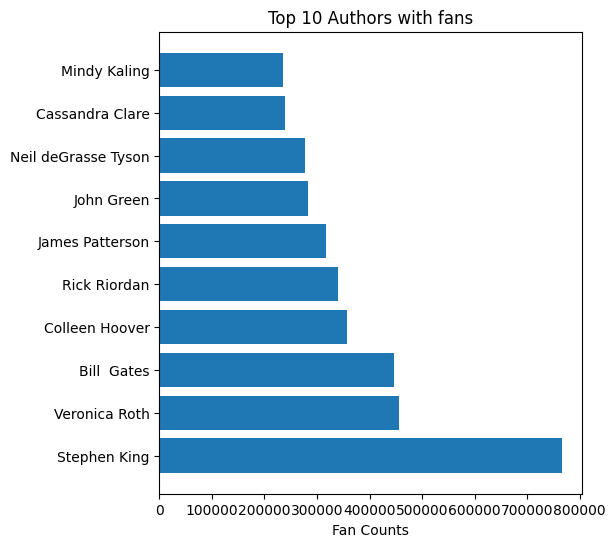

In [ ]:
#MY IDEA --> take the top 10 authors with the most fans for both files.

df = pd.DataFrame({
    'Author Name': df_lighter_authors['name'],
    'Fan Count': df_lighter_authors['fans_count'],
    'Number of Books': df_lighter_authors['book_ids']
})

# Sort the DataFrame by 'Influence Score' in descending order
sorted_df = df.sort_values(by='Fan Count', ascending=False)
# Select the top 10 authors
top_10_authors = sorted_df.head(10)
# Print the top 10 influential authors
print(top_10_authors[['Author Name', 'Fan Count', 'Number of Books']])

# Plot the data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(top_10_authors['Author Name'], top_10_authors['Fan Count'])
plt.xlabel('Fan Counts')
plt.title('Top 10 Authors with fans')

-------------------------------------------------

### RQ6.1 

Provide the average time gap between two subsequent publications for a series of books and those not belonging to a series. What do you expect to see, and what is the actual answer to this question?

In [ ]:
#MY IDEA --> import the dataset with only the columns I need. some of them will be needed later for other tasks 

json_file_path = 'lighter_books.json'
columns_to_read = ["author_name","publication_date","original_publication_date","series_name","series_position","title","average_rating","num_pages","language","format"]
chunk_size = 20000  
result_df = pd.DataFrame(columns=columns_to_read)
json_reader = pd.read_json(json_file_path, lines=True, chunksize=chunk_size)
for chunk in json_reader:
    chunk = chunk[columns_to_read]  
    result_df = pd.concat([result_df, chunk ], ignore_index=True)

print(result_df.head())

    author_name publication_date original_publication_date   series_name  \
0  J.K. Rowling          2004-09                2003-06-21  Harry Potter   
1  J.K. Rowling       2003-11-01                1997-06-26  Harry Potter   
2  J.K. Rowling       2003-11-01                1998-07-02  Harry Potter   
3  J.K. Rowling       2004-05-01                1999-07-08  Harry Potter   
4  J.K. Rowling       2002-09-28                2000-07-08  Harry Potter   

  series_position                                              title  \
0               5  Harry Potter and the Order of the Phoenix (Har...   
1               1  Harry Potter and the Sorcerer's Stone (Harry P...   
2               2  Harry Potter and the Chamber of Secrets (Harry...   
3               3  Harry Potter and the Prisoner of Azkaban (Harr...   
4               4  Harry Potter and the Goblet of Fire (Harry Pot...   

   average_rating num_pages language                 format  
0            4.50       870      eng            

In [ ]:
#MY IDEA --> take only the books written by these authors. 

df = pd.DataFrame({
    'Original Publication': result_df["original_publication_date"],
    'Author Name': result_df["author_name"],
    'Series Name': result_df["series_name"],
    "Serie Position": result_df["series_position"],
    "Title": result_df["title"],
    "Average Rating":result_df["average_rating"],
    "Pages":result_df["num_pages"],
    "Language":result_df["language"],
    "Format": result_df["format"]
})

specific_authors = ["Stephen King", "Veronica Roth","Bill  Gates" ,"Colleen Hoover", "Rick Riordan", "James Patterson", "John Green", "Neil deGrasse Tyson", "Cassandra Clare","Mindy Kaling"]

books_df = df[df["Author Name"].isin(specific_authors)]

print(books_df)

        Original Publication      Author Name  \
3114              2003-11-04     Stephen King   
3178              2004-09-21     Stephen King   
3179                    2002     Stephen King   
3180              2004-06-08     Stephen King   
3181                 1987-05     Stephen King   
...                      ...              ...   
7025403           2013-09-16  James Patterson   
7025474           1977-01-28     Stephen King   
7025621           2012-10-02     Rick Riordan   
7026344           2015-03-17  Cassandra Clare   
7026879           2011-06-09  James Patterson   

                                 Series Name Serie Position  \
3114                          The Dark Tower              5   
3178                          The Dark Tower              7   
3179                          The Dark Tower            1-4   
3180                          The Dark Tower              6   
3181                          The Dark Tower              2   
...                              

In [ ]:
###MY IDEA --> now I filter the data such that the books with a negative number of pages or equal to zero are eliminated. 
#I also remove all the different languages versions of a book

books_df['Pages'] = pd.to_numeric(books_df['Pages'], errors='coerce')

#remove 0 and negative
books_df = books_df[books_df['Pages'] > 0]

#take only english books, so that I remove all other version of the book
books_df = books_df[books_df['Language'] == "eng"]

In [ ]:
#mY IDEA --> make the dataframe such that there are only books that belong to a series. drop all the others. 
#then I need to clean the dataset by taking only ONE book per series per each position
#since I retained the original publication date, I do not care which I retain, the only thing that I care is that the date is specific and not only a year.
#at the very end, I remove all series that consists of just one book (therefore are not a series since it is only one book)


#removes all NA and empty values --> so I have only series books.
filtered_df = books_df[books_df['Series Name'].notna() | (books_df['Series Name'] != '')]

#drop all rows with "-" in the column series name (--> I'm doing so beacuse I want to remove some variables that have as value 1-4 or 1-6...)
filtered_df = filtered_df[filtered_df['Serie Position'].str.contains('-') == False]

#drop all rows that do not have two "- -". I am doing this because I am removing all dates that do not consist of year, month,day.
filtered_df = filtered_df[filtered_df['Original Publication'].str.count('-') == 2]


#now, since a lot (A LOT!) of my rows are composed by different publication of the same book, I just need one for each book for each series as I will use the 
#original publication date, which is equal for all the books, even for a different publication
filtered_df = filtered_df.drop_duplicates(subset=['Series Name', 'Serie Position'])

#remove all rows with the name of a series that compares only one time
counts = filtered_df['Series Name'].value_counts()
unique_series_names = counts[counts == 1].index
filtered_df = filtered_df[filtered_df['Series Name'].isin(unique_series_names) == False]

#now I have my clean dataframe :)
filtered_df

Original Publication      Author Name     Series Name Serie Position  \
3114              2003-11-04     Stephen King  The Dark Tower              5   
3178              2004-09-21     Stephen King  The Dark Tower              7   
3180              2004-06-08     Stephen King  The Dark Tower              6   
3183              1997-11-04     Stephen King  The Dark Tower              4   
3185              1982-06-01     Stephen King  The Dark Tower              1   
...                      ...              ...             ...            ...   
6800793           2015-11-23  James Patterson      Alex Cross             23   
6800795           2015-01-15  James Patterson         I Funny              3   
6953146           2016-03-14  James Patterson         Private             10   
6964407           2015-04-24  James Patterson   Middle School           7.25   
7002014           2016-01-19   Colleen Hoover     Never Never              3   

                                                     Title  Average Rating  \
3114              Wolves of the Calla (The Dark Tower, #5)            4.16   
3178                   The Dark Tower (The Dark Tower, #7)            4.24   
3180                 Song of Susannah (The Dark Tower, #6)            3.97   
3183                 Wizard and Glass (The Dark Tower, #4)            4.23   
3185                   The Gunslinger (The Dark Tower, #1)            3.94   
...                                                    ...             ...   
6800793                   Cross Justice (Alex Cross, # 23)            4.23   
6800795  I Totally Funniest: A Middle School Story: (I ...            4.38   
6953146                       Private Paris (Private, #10)            3.86   
6964407  Middle School: Rafe's Aussie Adventure (Middle...            4.30   
7002014          Never Never: Part Three (Never Never, #3)            3.49   

          Pages Language                 Format  
3114      931.0      eng  Mass Market Paperback  
3178     1050.0      eng              Paperback  
3180      544.0      eng  Mass Market Paperback  
3183      845.0      eng              Paperback  
3185      238.0      eng              Paperback  
...         ...      ...                    ...  
6800793   420.0      eng              Hardcover  
6800795   336.0      eng              Paperback  
6953146   141.0      eng              Hardcover  
6964407   320.0      eng              Paperback  
7002014   130.0      eng         Kindle Edition  

[212 rows x 9 columns]

In [ ]:
#MY IDEA --> now I have to print the average time between a publication. to do so, I need to make the original publication column into a datetime format. 
#then I sort it by series name and position so that I can calculate the difference between two subsequent publications for each series.
#then I take the average for each series

#eliminate all those books in which the series position is 0.5, 1.4 ecc
filtered_df = filtered_df[filtered_df['Serie Position'].str.isnumeric()]

#convert "Original Publication" column in a datetime format.
filtered_df['Original Publication'] = pd.to_datetime(filtered_df['Original Publication'])

#sort 
filtered_df = filtered_df.sort_values(by=['Series Name', 'Serie Position'])

#for each series, calculate the time difference between two subsequent publications
filtered_df['Time Gap'] = filtered_df.groupby('Series Name')['Original Publication'].diff()

#average
average_time_gap = filtered_df.groupby('Series Name')['Time Gap'].mean()

print(average_time_gap)


Series Name
Alex Cross                                  177 days 13:05:27.272727272
Confessions                                           464 days 16:00:00
Daniel X                                              556 days 04:48:00
Daniel X: The Manga                                   289 days 00:00:00
Divergent                                             455 days 12:00:00
Honeymoon                                            3052 days 00:00:00
Hopeless                                              203 days 00:00:00
I Funny                                               555 days 00:00:00
Maximum Ride                                          462 days 09:00:00
Maximum Ride: The Manga                               424 days 12:00:00
Maybe                                                               NaT
Michael Bennett                             442 days 20:34:17.142857144
Middle School                                         544 days 08:00:00
NYPD Red                                            

C:\Users\stefa\AppData\Local\Temp\ipykernel_12420\42724353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Original Publication'] = pd.to_datetime(filtered_df['Original Publication'])


In [ ]:
print(average_time_gap.mean())

855 days 00:52:07.174364112


### COMMENT

I did not understand the meaning of the question itself. I did not understand if I need to return the average gap time between books belonging to the same serie of books or the average gap time between all books belonging to a serie. Anyways, I provided both. The general time is 855 days.

If the time to return was the one for books belonging to the same series, then we have different times for each series. most of the publications are around one year, which is something reasonable. Few of them are above one year with some up to 8 years. This may be strange but in my opinion it is normal, just take as esample the times JRR Martin is taking for publishing a "Game of Thrones" book. 

There are some publications that have an average time very short (coupple of month or less) but inspecting them, they are all graphic novels, Mangas, short stories...
Yet, there is something that I would have not expect, there are few publications with time between 100 days and 355. Personally I find it strange to publish a book in few months or less than a year.

In [ ]:
### MY IDEA --> now I have to do the inverse, so I remove all books belonging to a serie, I clean the dataset by removing outliers in the date format, drop dublicates
#caused by the publishing again of the same book and then I proceed in couning the average time

books_df
filtered_df = books_df[books_df['Series Name'].notna() & (books_df['Series Name'] == '')]

#drop all rows that do not have two "- -". I am doing this because I am removing all dates that do not consist of year, month,day.
filtered_df = filtered_df[filtered_df['Original Publication'].str.count('-') == 2]

#there are 3 data ouliers with different time format, so I drop them.
date_pattern = r'^\d{4}-\d{2}-\d{2}$'
filtered_df = filtered_df[filtered_df['Original Publication'].str.match(date_pattern)]

#now, since a lot (A LOT!) of my rows are composed by different publication of the same book, I just need to take one of them.
#So I drop duplicates and keep only one and see its original date
filtered_df = filtered_df.drop_duplicates(subset=['Title'])


#now I have my clean dataframe :)
filtered_df = filtered_df.drop('Serie Position', axis=1)
filtered_df = filtered_df.drop('Series Name', axis=1)
filtered_df

Original Publication      Author Name  \
3416              1978-10-03     Stephen King   
3425              1975-10-17     Stephen King   
3535              1980-05-01  James Patterson   
4682              2002-06-10  James Patterson   
6607              2006-10-24     Stephen King   
...                      ...              ...   
6504774           2015-11-03     Stephen King   
6555083           2006-09-21       John Green   
6555457           2014-12-02     Stephen King   
6767963           2015-06-30     Stephen King   
6865907           2015-11-10   Colleen Hoover   

                                           Title  Average Rating   Pages  \
3416                                   The Stand            4.34  1344.0   
3425                                'Salem's Lot            4.25   594.0   
3535                              Cradle and All            3.86   384.0   
4682                             The Beach House            3.85   356.0   
6607                               Lisey's Story            3.68   513.0   
...                                          ...             ...     ...   
6504774                 The Bazaar of Bad Dreams            3.92   495.0   
6555083              The Abundance of Katherines            3.57   215.0   
6555457  Vertigo Essentials: American Vampire #1            3.88    64.0   
6767963                        Drunken Fireworks            3.53     2.0   
6865907                               November 9            4.34   320.0   

        Language          Format  
3416         eng       Hardcover  
3425         eng       Hardcover  
3535         eng       Paperback  
4682         eng       Paperback  
6607         eng       Hardcover  
...          ...             ...  
6504774      eng       Hardcover  
6555083      eng       Paperback  
6555457      eng  Kindle Edition  
6767963      eng       Audiobook  
6865907      eng  Kindle Edition  

[190 rows x 7 columns]

In [ ]:
### MY IDEA --> now I do again what I did before with the calculations

filtered_df['Original Publication'] = pd.to_datetime(filtered_df['Original Publication'])

# Sort the DataFrame by the "Original Publication" date
general_date_df = filtered_df.sort_values(by='Original Publication')

# Calculate the time gap between subsequent publications
general_date_df['Time Gap'] = general_date_df['Original Publication'].diff()

# Compute the average time gap
average_time_gap = general_date_df['Time Gap'].mean()

print(average_time_gap)

84 days 02:17:08.571428571


In [ ]:
#MY IDEA --> here instead, I do what I did for the series, bur instead of doing it by series, I am doing it by authors

# Convert the "Original Publication" column to datetime
filtered_df['Original Publication'] = pd.to_datetime(filtered_df['Original Publication'])

# Sort the DataFrame by the "Original Publication" date
author_date_df = filtered_df.sort_values(by='Original Publication')

# Calculate the time gap between subsequent publications
author_date_df['Time Gap'] = author_date_df.groupby('Author Name')['Original Publication'].diff()

# Compute the average time gap by author
average_time_gap_by_author = author_date_df.groupby('Author Name')['Time Gap'].mean()

print(average_time_gap_by_author)

Author Name
Bill  Gates                    1196 days 00:00:00
Cassandra Clare                               NaT
Colleen Hoover                  231 days 00:00:00
James Patterson       282 days 21:03:40.408163264
John Green                      306 days 22:24:00
Mindy Kaling                   1332 days 08:00:00
Neil deGrasse Tyson             733 days 00:00:00
Rick Riordan                   4128 days 00:00:00
Stephen King          148 days 21:24:42.352941176
Veronica Roth                   357 days 00:00:00
Name: Time Gap, dtype: timedelta64[ns]


### Comment

As before, I did not understand well the question. So I do not know if I have to return the average between all books or all books given an author. Nevertheless, here we have both results. The average overall average time (84 days) is something very unusual but can be explained because we are taking into considerations several authors who publish books often.
As before,  most of the authors have a "human" time of publications, but three (Stephen King, James Patterson, Colleen Hoover) have time very short. In particular, Stephen King has the shortest time between publications.

-----------------------------------------------------

### RQ6.2

For each of the authors, give a convenient plot showing how many books has the given author published UP TO a given year. Are these authors contemporary with each other? Can you notice a range of years where their production rate was higher?

In [ ]:
###MY IDEA --> Now I clean the dataset again by dropping all books with the same result and by dropping all books with an incorrect date format 
#I drop all books with dame title and for the series, I drop all books that have the same series name and the same series position.
#in order to do so, I will do it in two separate dataframes and then I will merge them
#then, I drop all books with the same original publication. I do this because if they have the same original publication,
#then it is the same book in a different version. I can do this because I only have 10 authors so it is very unlikely that they published a book in the same year, month ,day.

books_df

filtered_df = books_df.drop_duplicates(subset=['Title'])

#there are about 800 books with wrong datetime, I drop them
date_pattern = r'^\d{4}-\d{2}-\d{2}$'
filtered_df = filtered_df[filtered_df['Original Publication'].str.match(date_pattern)]

#filter by position removing outliers
filtered_df = filtered_df[filtered_df['Serie Position'].str.contains('-') == False]

#final filtering
filtered_df = filtered_df.drop_duplicates(subset=['Original Publication'])

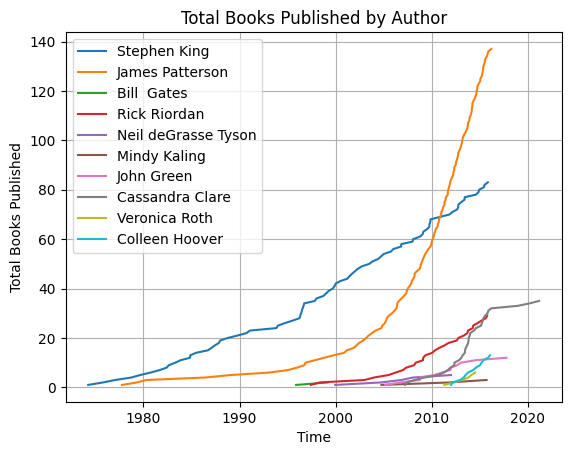

In [ ]:
#MY IDEA --> I transform the date and sort the result; then I group for each author, their books.

#convert date
filtered_df['Original Publication'] = pd.to_datetime(filtered_df['Original Publication'])

#sort
filtered_df = filtered_df.sort_values(by='Original Publication')

#count
filtered_df['Books Published'] = filtered_df.groupby('Author Name')['Original Publication'].cumcount() + 1

#plot
authors = filtered_df['Author Name'].unique()
for author in authors:
    author_df = filtered_df[filtered_df['Author Name'] == author]
    plt.plot(author_df['Original Publication'], author_df['Books Published'], label=author)

plt.xlabel('Time')
plt.ylabel('Total Books Published')
plt.title('Total Books Published by Author')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### Comment

The authors are more or less all contemporary to each other expect for Stephen King and James Patterson. These two are contemporary to the others in the sense that they still publish books when the other started publishing but as we can see, King and Patterson started way before the others but continued to publish while the other started.

-------------------------------------------------------

# [RQ7] Estimating probabilities is a core skill for a data scientist: show us your best!

## 1. Estimate the probability that a book has over 30% of the ratings above 4.

In [ ]:
df_rating_dist = df_lighter_books.select("rating_dist").toPandas() # convert the rating_dist column to a pandas dataframe

In [ ]:
df_rating_dist.head() # print the first 5 rows of the dataframe

rating_5  rating_4  rating_3  rating_2  rating_1    total
0   1674064    664833    231195     41699     16215  2628006
1   4801606   1681521    623286    145898    125040  7377351
2   1690166    781011    313727     54687     15453  2855044
3   1994597    696545    212678     28915     13959  2946694
4   1808039    663849    193604     27759     12425  2705676

In [ ]:
# Assuming df_rating_dist is your dataframe
df_rating_dist = func.preprocess(df_rating_dist)

In [ ]:
df_rating_dist.head() # print the first 5 rows of the dataframe

rating_5  rating_4  rating_3  rating_2  rating_1    total
0   1674064    664833    231195     41699     16215  2628006
1   4801606   1681521    623286    145898    125040  7377351
2   1690166    781011    313727     54687     15453  2855044
3   1994597    696545    212678     28915     13959  2946694
4   1808039    663849    193604     27759     12425  2705676

In [ ]:
df_rating_dist.describe() # print the summary statistics of the dataframe

rating_5      rating_4      rating_3      rating_2      rating_1  \
count  7.027431e+06  7.027431e+06  7.027431e+06  7.027431e+06  7.027431e+06   
mean   8.006048e+03  6.271244e+03  3.635023e+03  1.049196e+03  4.970985e+02   
std    7.733876e+04  4.876856e+04  2.701399e+04  8.667411e+03  5.197083e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
50%    1.300000e+01  1.400000e+01  1.100000e+01  3.000000e+00  1.000000e+00   
75%    2.320000e+02  2.620000e+02  1.830000e+02  4.600000e+01  1.500000e+01   
max    4.816896e+06  1.993815e+06  1.051455e+06  5.605970e+05  5.625020e+05   

              total  
count  7.027431e+06  
mean   1.945861e+04  
std    1.609008e+05  
min    0.000000e+00  
25%    3.000000e+00  
50%    4.500000e+01  
75%    7.710000e+02  
max    7.400639e+06

In [ ]:
for col in df_rating_dist.columns: # for each column in the dataframe 
    df_rating_dist.loc[df_rating_dist[col] < 0, col] = 0 # replace negative values with 0

In [ ]:
df_rating_dist.describe() # print the summary statistics of the dataframe

rating_5      rating_4      rating_3      rating_2      rating_1  \
count  7.027431e+06  7.027431e+06  7.027431e+06  7.027431e+06  7.027431e+06   
mean   8.006048e+03  6.271244e+03  3.635023e+03  1.049196e+03  4.970985e+02   
std    7.733876e+04  4.876856e+04  2.701399e+04  8.667411e+03  5.197083e+03   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    1.000000e+00  1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00   
50%    1.300000e+01  1.400000e+01  1.100000e+01  3.000000e+00  1.000000e+00   
75%    2.320000e+02  2.620000e+02  1.830000e+02  4.600000e+01  1.500000e+01   
max    4.816896e+06  1.993815e+06  1.051455e+06  5.605970e+05  5.625020e+05   

              total  
count  7.027431e+06  
mean   1.945861e+04  
std    1.609008e+05  
min    0.000000e+00  
25%    3.000000e+00  
50%    4.500000e+01  
75%    7.710000e+02  
max    7.400639e+06

In [ ]:
df_rating_dist['percentage_4_above'] = (df_rating_dist['rating_5'] + df_rating_dist['rating_4']) / df_rating_dist['total'] # add a column with the percentage of ratings 4 and above

In [ ]:
num_books_over_30 = df_rating_dist[df_rating_dist['percentage_4_above'] > 0.3].shape[0] # count the number of books with percentage of ratings 4 and above greater than 30%

In [ ]:
total_books = df_rating_dist.shape[0] # count the total number of books
probability = num_books_over_30 / total_books # calculate the probability

In [ ]:
probability # print the probability

0.805691866629498

The probability that a book has over 30% of the ratings above 4 is `0.805691866629498`

--------------------------------------------

## 2. Estimate the probability that an author publishes a new book within two years from its last work.

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col('author_id')) != '') #  removes rows with empty author_id
df_lighter_books = df_lighter_books.filter(trim(col('original_publication_date')) != '') #  removes rows with empty original_publication_date
df_lighter_books = df_lighter_books.dropna(subset=['original_publication_date', 'author_id']) # removes rows with null values in original_publication_date and author_id

In [ ]:
df_within_two_years = df_lighter_books.select("author_id", "original_publication_date").toPandas() # convert the author_id and original_publication_date columns to a pandas dataframe

In [ ]:
df_within_two_years.info() # print the first 5 rows of the dataframe

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6513825 entries, 0 to 6611684
Data columns (total 2 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   author_id                  int64         
 1   original_publication_date  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 149.1 MB


In [ ]:
# Convert the original_publication_date column to datetime type
df_within_two_years['original_publication_date'] = pd.to_datetime(df_within_two_years['original_publication_date'], errors='coerce')

In [ ]:
df_within_two_years = df_within_two_years.dropna(subset=['original_publication_date']) # removes rows with null values in original_publication_date

In [ ]:
df_within_two_years.head() # print the first 5 rows of the dataframe

author_id original_publication_date time_diff  time_diff_years  \
6161803      16244                1678-01-01    0 days              0.0   
18772        16244                1678-01-01    0 days              0.0   
5337206      18457                1678-01-01    0 days              0.0   
6085994     401826                1678-01-01    0 days              0.0   
5047620      18457                1678-01-01    0 days              0.0   

         published_within_two_years  
6161803                        True  
18772                          True  
5337206                        True  
6085994                        True  
5047620                        True

In [ ]:
df_within_two_years = df_within_two_years.sort_values('original_publication_date', ascending=True) # sort the dataframe by original_publication_date

In [ ]:
# Calculate the difference between each date and the previous one
df_within_two_years['time_diff'] = df_within_two_years['original_publication_date'].diff()

In [ ]:
df_within_two_years = df_within_two_years.dropna(subset=['time_diff']) # removes rows with null values in time_diff

In [ ]:
# Convert the difference to years
df_within_two_years['time_diff_years'] = df_within_two_years['time_diff'].dt.days / 365.25

In [ ]:
# Find the instances where the difference is less than or equal to 2
df_within_two_years['published_within_two_years'] = df_within_two_years['time_diff_years'] <= 2

In [ ]:
# Calculate the probability
probability = df_within_two_years['published_within_two_years'].mean()

In [ ]:
probability # print the probability

0.9999976972052054

The probability that an author publishes a new book within two years from its last work is `0.9999976972052054`

--------------------------------------------

## 3. In the file list.json, you will find a peculiar list named "The Worst Books of All Time." Estimate the probability of a book being included in this list, knowing it has more than 700 pages.

In [ ]:
df_list_x = df_list.filter(df_list['title'] == "The Worst Books of All Time") # filter the dataframe to keep only the rows with title "The Worst Books of All Time"

In [ ]:
df_list_x.show() # print the dataframe

+--------------------+--------------------+--------------+--------------------+--------------------+---+---------+------------+---------+---------+----------+--------------------+--------------------+
|               books|          created_by|  created_date|         description|    description_html| id|num_books|num_comments|num_likes|num_pages|num_voters|                tags|               title|
+--------------------+--------------------+--------------+--------------------+--------------------+---+---------+------------+---------+---------+----------+--------------------+--------------------+
|[{Stephenie Meyer...|{73, Michael Econ...|May 20th, 2008|What do you think...|\n      What do y...|  2|     7395|        2570|      175|       74|     18260|[abominable, abom...|The Worst Books o...|
+--------------------+--------------------+--------------+--------------------+--------------------+---+---------+------------+---------+---------+----------+--------------------+-----------------

In [ ]:
# Get the list of book IDs
df_flattened = df_list_x.select(explode(df_list_x.books).alias("books"))
df_book_ids = df_flattened.select("books.book_id")

In [ ]:
df_book_ids.sort(col("book_id").desc()).show() # print the book IDs

+-------+
|book_id|
+-------+
|   9998|
|9996645|
|  99944|
| 998133|
| 997668|
|9972882|
|9972053|
|9969571|
|9961659|
|  99610|
|9960089|
|   9957|
|  99561|
|9954020|
|  99452|
|   9943|
| 993849|
|  99383|
| 993455|
|  99329|
+-------+
only showing top 20 rows



In [ ]:
# Convert df_book_ids to a list
book_ids_list = [row['book_id'] for row in df_book_ids.collect()]

# Select rows from df_lighter_books where id is in book_ids_list
df_selected = df_lighter_books.filter(df_lighter_books.id.isin(book_ids_list))

# Select id and num_pages columns
df_selected = df_selected.select('id', 'num_pages')

In [ ]:
# sort the dataframe by num_pages in descending order
df_selected.sort(col("id").desc()).show()

+--------+---------+
|      id|num_pages|
+--------+---------+
|25494343|      698|
|25451852|      712|
|25448677|      250|
|25437276|      392|
|25436458|      600|
|25434341|      272|
|25425999|      128|
|25410020|     NULL|
|25389154|     NULL|
|25324111|      486|
|25304748|      275|
|25278664|      336|
|25263605|      256|
|25261897|      368|
|25257622|      288|
|25251380|     NULL|
|25199464|     NULL|
|25161131|      422|
|25147910|       14|
|25143499|      348|
+--------+---------+
only showing top 20 rows



In [ ]:
df_selected.count() # count the number of rows

6228

In [ ]:
df_book_ids.count() # count the number of rows

7393

In [ ]:
# Number of books in list with >700 pages
num_books_over_700 = df_selected.filter(df_selected['num_pages'] > 700).count()

In [ ]:
num_books_over_700 # print the number of books in list with >700 pages

220

In [ ]:
# Total number of books with >700 pages in df_lighter_books
total_books_over_700 = df_lighter_books.filter(df_lighter_books['num_pages'] > 700).count()

In [ ]:
total_books_over_700 # print the total number of books with >700 pages in df_lighter_books

111120

In [ ]:
# P(book in list | book has >700 pages) = (Number of books in list with >700 pages) / (Total number of books with >700 pages)
probability = num_books_over_700 / total_books_over_700

In [ ]:
# Print the probability
probability

0.0019798416126709864

The probability of a book being included in this list, knowing it has more than 700 pages is `0.0019798416126709864`

----------------------------------------------------

## 4. Are the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ independent? Explain how you have obtained your answer.

In probability theory, two events are said to be independent if the probability of one event occurring does not affect the probability of the other event. Formally, events X and Y are independent if and only if P(X ∩ Y) = P(X)P(Y).

P(X): The probability of a book being included in "The Worst Books of All Time" list, which can be calculated by dividing the number of books in the list by the total number of books considered.

P(Y): The probability of a book having more than 700 pages, which can be calculated by dividing the number of books with more than 700 pages by the total number of books considered.

P(X ∩ Y): The probability of both events happening, i.e., a book being in the list and having more than 700 pages. This can be calculated by dividing the number of books in the list that have more than 700 pages by the total number of books considered.

If P(X ∩ Y) equals P(X)P(Y), then the events X and Y are independent. If not, they are not independent, meaning the occurrence of one event does influence the probability of the other event.

In [ ]:
# P(X): The probability of a book being included in "The Worst Books of All Time" list, which can be calculated by dividing the number of books in the list by the total number of books considered.
px = df_selected.count() / df_lighter_books.count()

In [ ]:
# P(Y): The probability of a book having more than 700 pages, which can be calculated by dividing the number of books with more than 700 pages by the total number of books considered.
py = df_lighter_books.filter(df_lighter_books['num_pages'] > 700).count() / df_lighter_books.count()

In [ ]:
# P(X,Y): The probability of a book being included in "The Worst Books of All Time" list and having more than 700 pages, which can be calculated by dividing the number of books in the list with more than 700 pages by the total number of books considered.
pxy = df_selected.filter(df_selected['num_pages'] > 700).count() / df_lighter_books.count()

In [ ]:
px  # print P(X)

0.0008862413590400248

In [ ]:
py # print P(Y)

0.015812321743180403

In [ ]:
print(pxy) # print P(X,Y)

3.130589258009079e-05


In [ ]:
print(px * py) # print P(X) * P(Y)

1.4013533511254334e-05


In [ ]:
# check if P(X,Y) = P(X) * P(Y)
pxy == px * py

False

Therefore we can conclude that the events X=’Being Included in The Worst Books of All Time list’ and Y=’Having more than 700 pages’ are `not independent`.

-----------------------------------------------------

# [RQ8] Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

- Can you demonstrate that readers usually rate the longest books as the worst?

It seems from the research question that we are looking for whether there is a negative correlation between the number of pages a book has and the average number of reviews it has received. What we come up with is to do a scatterplot of the two variables and see if it is possible to make a regression line that has a negative angular coefficient.
We are considering both the number of pages and the average number of reviews as continuous quantitative variables. 
We also calculate the correlation between the two variables and see if the results we find graphically and with the formulas are consistent with our hypotheses. 
We can also do a Pearson test to see if the correlation is significant.

In [ ]:
df_lighter_books = df_lighter_books.filter(trim(col("num_pages")) != "") # removes rows with empty language
df_lighter_books = df_lighter_books.filter(trim(col("average_rating")) != "")
df_lighter_books = df_lighter_books.dropna(subset=["num_pages","average_rating"])

In [ ]:
ratings_count = df_lighter_books.select("ratings_count").toPandas()
pages_and_ratings = df_lighter_books.select("num_pages","average_rating").toPandas() #takes 5 minutes to run

In [ ]:
# Let's look at our quantiles to eliminate a bit of outliers to permorm the scatterplot
np.max(pages_and_ratings["num_pages"])
q_pages = np.quantile(pages_and_ratings["num_pages"], q = 0.999) #we use this quantile to esclude number of pages too big
q_ratings = np.quantile(ratings_count["ratings_count"], q = 0.2)
q_min_pages = np.quantile(pages_and_ratings["num_pages"], q = 0.2)

In [ ]:
filtered_pages_and_ratings = df_lighter_books.filter((df_lighter_books["ratings_count"] >= q_ratings) & (df_lighter_books["num_pages"] >= q_min_pages) & (df_lighter_books["num_pages"] <= q_pages)).select("num_pages", "average_rating").toPandas()

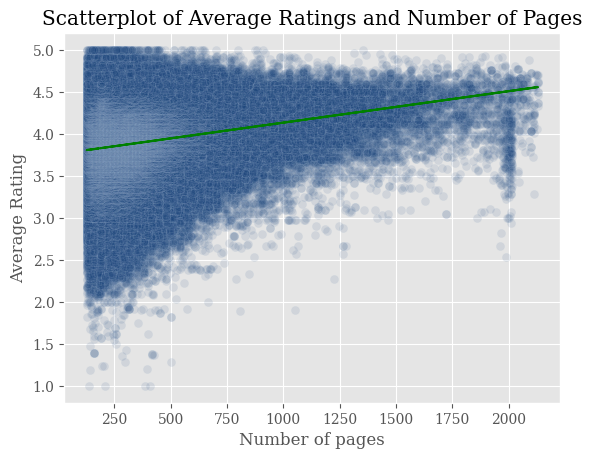

In [ ]:
plt.scatter(filtered_pages_and_ratings["num_pages"], filtered_pages_and_ratings["average_rating"], alpha=0.1, edgecolors = 'lightsteelblue')

slope, intercept = np.polyfit(filtered_pages_and_ratings["num_pages"], filtered_pages_and_ratings["average_rating"], 1)
plt.plot(filtered_pages_and_ratings["num_pages"], slope*filtered_pages_and_ratings["num_pages"]+intercept, color = "green") 
plt.title("Scatterplot of Average Ratings and Number of Pages")
plt.xlabel("Number of pages")
plt.ylabel("Average Rating")
plt.show()

In [ ]:
rho = stats.pearsonr(filtered_pages_and_ratings["num_pages"], filtered_pages_and_ratings["average_rating"])
r = rho[0]

# What do we expect? From the plot shown above, is clear that there is some linear relationship... so we expect to see a rho that is not too high.
# At the same time we know that our sample size is very big... it is almost an asymptotic! So we expect to see a p-value really really low...

p_value = rho[1]

# And in fact:

print('The Pearson correlation coefficient is', r)
print('The corrisponding p-value is', p_value)

The Pearson correlation coefficient is 0.1978015443204692
The corrisponding p-value is 0.0


The scatterplot did not yield the result we hoped for, so to try to show that reviews become negative for books with many pages we try to turn average rating into a dichotomous variable and try to use a logistic regression

In [ ]:
threshold = 3.5  # Under 3.5 is a bad rating
# New column "rating_binary"
df_lighter_books = df_lighter_books.withColumn("rating_binary", when(df_lighter_books["average_rating"] >= threshold, 1).otherwise(0))

In [ ]:
pages_and_Binary = df_lighter_books.select("num_pages", "rating_binary").toPandas()

In [ ]:
pages_and_binary_filtered = pages_and_Binary[pages_and_Binary["num_pages"] <=  np.quantile(pages_and_Binary["num_pages"], q = 0.999)] #filtering the data

In [ ]:
X = pages_and_binary_filtered["num_pages"].values.reshape(-1, 1)
y = pages_and_binary_filtered["rating_binary"].values

# Create and fit a logistic regression model
logistic_reg = LogisticRegression()
logistic_reg.fit(X, y)

# Plot the logistic curve
y_prob = logistic_reg.predict_proba(X)[:, 1]

In [ ]:
intercept = logistic_reg.intercept_[0]
coefficient = logistic_reg.coef_[0][0]
print("The coefficient of the logistic regression is:", coefficient)

The coefficient of the logistic regression is: 0.0023039983447515986


In [ ]:
plt.rcParams['agg.path.chunksize'] = 10000 #searched online after an error, is for visualizing lot of points

Text(0.5, 1.0, 'Plot of the logistic curve')

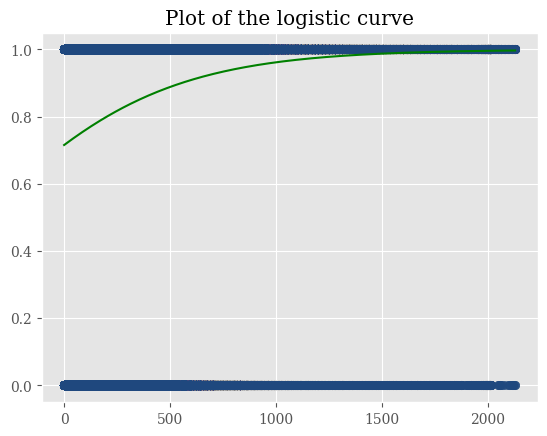

In [ ]:
X_curve = np.linspace(min(X), max(X), 300).reshape(-1, 1) #x data

y_prob_curve = logistic_reg.predict_proba(X_curve)[:, 1] #y predictions

plt.scatter(X, y, alpha=0.6)
plt.plot(X_curve, y_prob_curve, color="green")
plt.title("Plot of the logistic curve")

After our attempts we can conclude that there is no negative correlation or a negative relationship between the two variables. Although linear regression summarized the behavior of the data well, with logistic regression we create a curve that seems to follow the pattern of the scatterplot better. <br>
We therefore conclude that as the number of pages increases the reviews are higher, perhaps, after reading a really long book one tends to review it well, if the reader does not like the book maybe he stops reading it before finishing it and does not review it at all.

- Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?


In [ ]:
# From the pie-chart of the languages we have seen that most of the books are english book but if we look at the other categories we can see that there are also "en-US" and "en-GB"
# and we will put them together with "eng".
# So we want to construct a new column with English and Non-English books
df_lighter_books = df_lighter_books.withColumn("language_standard", when(col("language").isin("en-US", "en_GB", "eng"), "eng").otherwise("non-eng"))
df_languages_standard = df_lighter_books.select("title","language_standard","average_rating").toPandas()
# Now our data is ready

In [ ]:
df_languages_standard["language_standard"].value_counts()
# So our population is composed by 812523 non-eng books and 770773 eng books.

non-eng    812523
eng        770773
Name: language_standard, dtype: int64

To compare the distribution of the average rating for English lirbs and non-English books, the T-test can be used.
It is a test-parametric test used to determine whether there is a statistically significant difference between the means of two distributions. The t-test is based on three assumptions:
1) independent samples
2) data with approximately normal distribution
3) homogeneity of variance

However, the t-test is robust in case the data are not normal but works well usually for small samples.

In our case the samples are independent because they are drawn from two different subpopulations, we can leave out the normality in the t-test and go to calculate the population variance, np.var calculates the population variance, in this case we do not need the sample variance because we have the whole population available. However from the point of view of time and calculations we often use the sample variance and use samples from the population.

In [ ]:
random.seed(42)

# Sample the data
eng_ratings = random.sample(df_languages_standard[df_languages_standard["language_standard"] == "eng"]["average_rating"].tolist(), 1000)
non_eng_ratings = random.sample(df_languages_standard[df_languages_standard["language_standard"] == "non-eng"]["average_rating"].tolist(), 1000)
print(np.var(eng_ratings))
print(np.var(non_eng_ratings))
# our variances do not differ much, and so we can use the equal_var = True argument of the t-test
t_stat, p_value = stats.ttest_ind(eng_ratings, non_eng_ratings, equal_var=True)  # Assuming equal variances and the default method is two-sided
print("The value of the t statistics is:", t_stat, "and the value of the p-value is: ", p_value)

0.7931538774999999
0.5778219951
The value of the t statistics is: -0.4610581512906193 and the value of the p-value is:  0.6448070679699869


From the result of the t-test, the p-value is greater than 0.05, so we accept the null hypothesis. Therefore, there does not seem to be a significant difference between the means of the two distributions.

We do not stop our analysis here because we have so much data available, and the t-test is usually used on small samples; an alternative to the t-test is the z-test, which precisely is used when the sample size is high.
The z-test has as assumptions that:
1) The data are normal
2) The samples are independent
3) The variance is known
4) the sample size is large

In the literature we do not find as for the t-test the confidence that the test performs well even if the data is not normal so we have to verify it, we can do it either with a test or graphically.

Kolmogorov-Smirnov statistic for eng_rating: 0.9472074376523145
P-Value for eng_rating: 0.0
Kolmogorov-Smirnov statistic for non_eng_rating: 0.9609754114572416
P-Value for non_eng_rating: 0.0


Text(0, 0.5, 'Frequency')

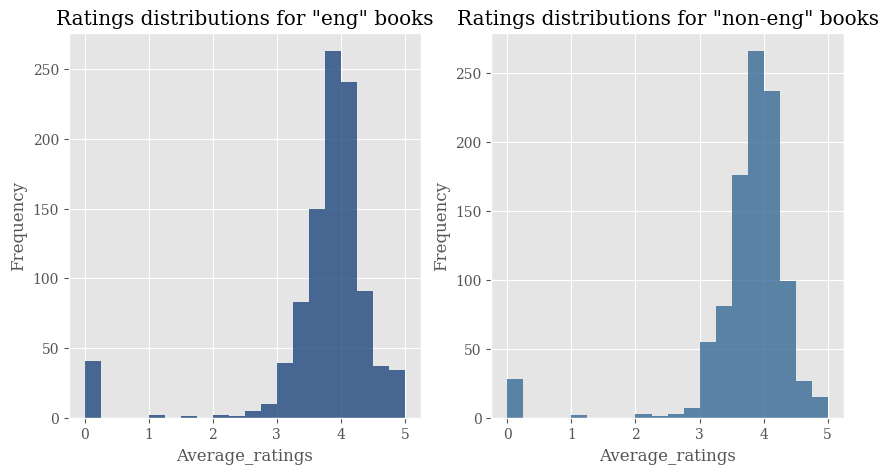

In [ ]:
stat, p = stats.kstest(eng_ratings, 'norm')
print("Kolmogorov-Smirnov statistic for eng_rating:", stat)
print("P-Value for eng_rating:", p)

stat_n, p_n = stats.kstest(non_eng_ratings, 'norm')
print("Kolmogorov-Smirnov statistic for non_eng_rating:", stat_n)
print("P-Value for non_eng_rating:", p_n)

# Both p-value are under 0.05 so our samples are not normally distributed...
# We can check it also graphically

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].hist(eng_ratings, bins=20, alpha=0.8, label='eng', color = our_colors[0] )
axes[0].set_title('Ratings distributions for "eng" books')
axes[0].set_xlabel('Average_ratings')
axes[0].set_ylabel('Frequency')

# Plot per la distribuzione dei dati del gruppo "non-eng"
axes[1].hist(non_eng_ratings, bins=20, alpha=0.8, label='non-eng', color = our_colors[2])
axes[1].set_title('Ratings distributions for "non-eng" books')
axes[1].set_xlabel('Average_ratings')
axes[1].set_ylabel('Frequency')


As we can see both graphically and with the test, we cannot assume that the sample data are normal. Therefore, we are not going to use the Z-test. <br>
From the graph we also see that the shape of the two distributions is almost the same, maybe the t-test we did is attentible but we still choose to do a nonparametric test as well such as the Wilcoxon-Mann-Whitney test. With a nonparametric test we make no assumptions about the distribution of the data, we will still get a test statistic and p-value but for example we will not have the confidence intervals.

We then go on to explore the test of Wilcoxon which is a non-parametric statistical test used to compare the medians of two groups. <br>
The test assumptions are:
1) The observations from the two groups should be randomly selected from the target populations.
2) Observations are independent of each other.
3) Observations should be continuous or ordinal. 

The null hypothesis is that the distribution of non-english average ratings books is the same as the distribution of english average ratings book.

In [ ]:
statistic, p_value = mannwhitneyu(eng_ratings, non_eng_ratings)
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 512281.0
p-value: 0.34154855244878934


So even the nonparametric test gives a p-value greater than 0.05 so we accept the null hypothesis and conclude that there is no statistically significant difference between the two groups. <br>

Therefore, going beyond statistical significance we can conclude that there is no clear evidence to be able to say that language affects the distribution of average ratings, so the fact that a book is written in English or in another language does not significantly change the grade the reader will give the book. <br>
Should one wish to make a more accurate analysis of the average rating of books written in English or another language one would also need to consider other factors besides the distribution of the average rating itself such as the genre of the book, the writer, and even the audience itself being considered. 

- About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

In [ ]:
eng = df_languages_standard[df_languages_standard["language_standard"] == "eng"]["average_rating"]
non_eng = df_languages_standard[df_languages_standard["language_standard"] == "non-eng"]["average_rating"]

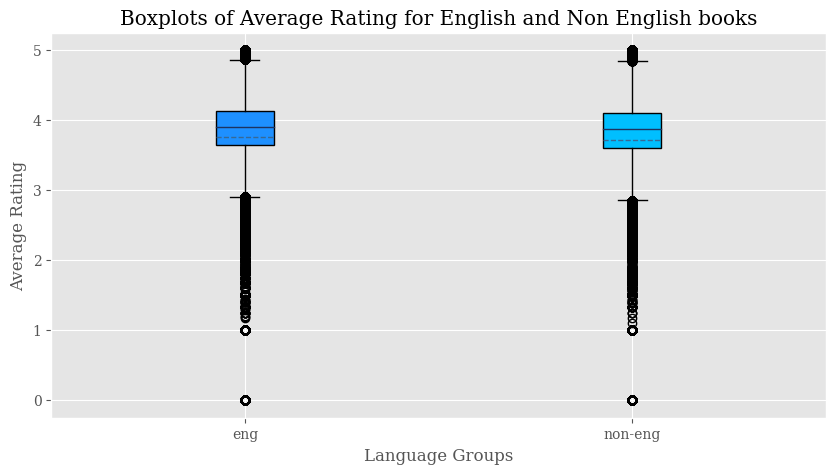

English books: 
 Mean: 3.7536994679367313 
 Mode: 4.0 
 Median: 3.91 
 First Quartile:  3.64 
 Third Quartile:  4.13

Non English books: 
 Mean: 3.7176398206573826 
 Mode: 4.0 
 Median: 3.88 
 First Quartile:  3.6 
 Third Quartile:  4.1


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))

bplot1 = ax.boxplot(eng, positions=[1], labels=["eng"], patch_artist=True, showmeans=True, meanline = True)
bplot2 = ax.boxplot(non_eng, positions=[2], labels=["non-eng"], patch_artist=True, showmeans=True, meanline = True)
ax.set_xlabel('Language Groups')
ax.set_ylabel('Average Rating')

for box, color in zip(bplot1['boxes'], ['dodgerblue']):
    box.set_facecolor(color)

for box, color in zip(bplot2['boxes'], ['deepskyblue']):
    box.set_facecolor(color)
plt.title("Boxplots of Average Rating for English and Non English books")
plt.show()


print("English books:", "\n", "Mean:" ,np.mean(eng), "\n","Mode:", mode(eng),"\n", "Median:" ,np.median(eng), "\n", "First Quartile: ", np.quantile(eng,q=0.25), "\n", "Third Quartile: ", np.quantile(eng,q=0.75))
print()
print("Non English books:", "\n", "Mean:" ,np.mean(non_eng), "\n","Mode:", mode(non_eng),"\n", "Median:" ,np.median(non_eng), "\n", "First Quartile: ", np.quantile(non_eng,q=0.25), "\n", "Third Quartile: ", np.quantile(non_eng,q=0.75))

We modified the boxplot to also show the mean using the showmean argument; the mean is the dotted line inside the box and in the classic boxplot it is not represented. <br>
The other line inside the boxplot represents the mean, the second quartile. <br> 
The first and third quartiles are the extremes of the box, and the size of the box represents the interquartile range. <br>
All the dots that we see are the values that are considered outliers, in fact if we look again at the book sample distribution graph we will see that most of the data are concentrated between 3 and 5 and therefore the boxplot considers all those it finds below the value 3 to be outlier data. <br>
The other two black horizontal lines represent the minimum and maximum value of the distribution. <br>
Having also displayed the mean in the boxplot we can also have additional information regarding the skewness of the distribution. When the mean is smaller than the median there is negative skewness i.e. the distribution has a long tail on the left, vice versa if the mean is larger than the median. <br>
If the mean and median do not coincide, it is also concluded that you do not have a normal distribution. <br>

The values for the two distriubutions we obtain are very similar, thus again confirming the results of the previous question.

- It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical   test or a predictive model.

In [ ]:
# For this task we use the authors dataset and we clean a bit the data
df_lighter_authors = df_lighter_authors.filter(trim(col("name")) != "") # removes rows with empty name
df_lighter_authors = df_lighter_authors.filter(trim(col("fans_count")) != "") # removes rows with empty fans_count
df_lighter_authors = df_lighter_authors.filter((col("text_reviews_count") >= 0) & (col("fans_count") >= 0)) #removes negatives values
df_lighter_authors = df_lighter_authors.filter(trim(col("text_reviews_count")) != "") # removes rows with empty text_review_count
df_lighter_authors = df_lighter_authors.dropna(subset=["name","fans_count","text_reviews_count"])

In [ ]:
fans_and_reviews = df_lighter_authors.select("name","fans_count","text_reviews_count").orderBy("fans_count", ascending=False).toPandas()
fans_and_reviews # well, Stephen King fans are not lazy!

name  fans_count  text_reviews_count
0                   Stephen King      766035              608956
1                  Veronica Roth      455358              277033
2                 Colleen Hoover      356633              240302
3                   Rick Riordan      339346              354145
4                James Patterson      317040              333220
...                          ...         ...                 ...
248369         Peter       Moore           0                   0
248370           Luise Zschöttge           0                   0
248371  Manuel Martínez Sospedra           0                   1
248372             Evelyn Wylder           0                   3
248373               Mukunda Das           0                   0

[248374 rows x 3 columns]

As with the first question to investigate whether there is some sort of relationship between fans_count and text_reviews_rating we can either rely on a correlation test or a predictive model such as linear regression. <br>
We can do both and see if the results are consistent.

In [ ]:
np.max(fans_and_reviews["fans_count"]) #maximum level = 766035
fans_99 = np.quantile(fans_and_reviews["fans_count"], q = 0.99) # 99-th percentile = 1620
# we need to trim the data
np.max(fans_and_reviews["text_reviews_count"]) #maximum level = 608956
text_99 = np.quantile(fans_and_reviews["text_reviews_count"], q = 0.99) # 99-th percentile = 6538

In [ ]:
# Filtering the data according with the quatiles of the distributions
filtered_fans_and_reviews = fans_and_reviews[(fans_and_reviews["fans_count"] <= fans_99) & (fans_and_reviews["text_reviews_count"] <= text_99)]

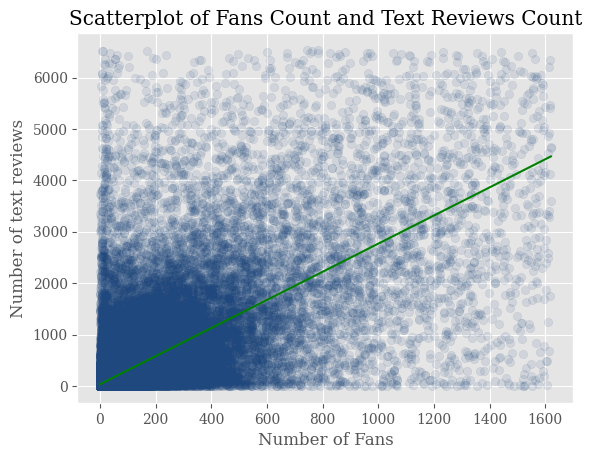

In [ ]:
plt.scatter(filtered_fans_and_reviews["fans_count"], filtered_fans_and_reviews["text_reviews_count"], alpha=0.1)

slope, intercept = np.polyfit(filtered_fans_and_reviews["fans_count"], filtered_fans_and_reviews["text_reviews_count"], 1)
plt.plot(filtered_fans_and_reviews["fans_count"], slope*filtered_fans_and_reviews["fans_count"]+intercept, color = "green") 
plt.title("Scatterplot of Fans Count and Text Reviews Count")
plt.xlabel("Number of Fans")
plt.ylabel("Number of text reviews")
plt.show()
# Well... we have so much data that fitting a linear regression is not so helpfull, we can not say that from the scatter there is a perfect linear relation

In [ ]:
# We can still try to do a predictive linear model

# Set X and Y and split the data
X = filtered_fans_and_reviews[["fans_count"]]
y = filtered_fans_and_reviews["text_reviews_count"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the model
model_lm = LinearRegression()
# Train the model
model_lm.fit(X_train, y_train)
# Predictions
y_pred = model_lm.predict(X_test)
# Results
print("The R^2 value is:", round(r2_score(y_test, y_pred),3), "and the value of the coefficient is:", round(model_lm.coef_[0],3))

The R^2 value is: 0.499 and the value of the coefficient is: 2.735


To understand whether the model explains enough variance in the data, we can use R squared. <br>
It is a measure that is the proportion of the variation in the dependent variable (in this case text_reviews_count) that is predictable from the independent variable (in this case fans_count). <br>
Usually the values range from 0 to 1 where 1 corresponds to perfect predictions. In our case we obtained an R^2 of about 0.5 so the linear regression model cannot explain all the variance in the data. <br>
The coefficient we obtain is a positive coefficient and so as the variable "fans_count" increases by one unit we will see a positive increase in the variable "text_review_count" <br>
In this case we do not see the lazy behavior of fans, according to our model as the number of fans increases so do the number of reviews.

Let us also see the correlation value and whether this value is statistically signficant

We can use the Pearson correlation but it needs:
1) Normally distributed variables
2) Linear relation between the variables
3) There are not outliers

In our case we are assuming 2) and we checked the 3) using the quantiles of the distribution, we are not sure about the normality of our data, so we can do also the Spearmna correlation which is the same formula of Pearson Correlation but it is applied to the ranks of the variables and it is not parametric so we can skip the normality of the data.

In [ ]:
rho = stats.pearsonr(filtered_fans_and_reviews["fans_count"], filtered_fans_and_reviews["text_reviews_count"])
r = rho[0]
p_value = rho[1]

print('The Pearson correlation coefficient is', r)
print('The corrisponding p-value is', p_value)
# The correlation is 0.7 so there is positive correlation between the variables and the coefficient is significative

The Pearson correlation coefficient is 0.7099858362419893
The corrisponding p-value is 0.0


In [ ]:
rho = stats.spearmanr(filtered_fans_and_reviews["fans_count"], filtered_fans_and_reviews["text_reviews_count"])
r = rho[0]
p_value = rho[1]
print('The Spearman correlation coefficient is', r)
print('The corrisponding p-value is', p_value)

The Spearman correlation coefficient is 0.7656527137769905
The corrisponding p-value is 0.0


With both Spearman's and Pearson's correlation, we obtained that there is a positive correlation between the two variables.  We therefore conclude that authors with more fans do not have lazy fans and they therefore write a large number of reviews. <br>
However, it must be remembered that correlation does not imply causality.

We can then also do a statistical test by taking the 1000 most popular authors, and among the remaining authors another 1000 are sampled by simple random sampling without repetition.

Text(0, 0.5, 'Frequency')

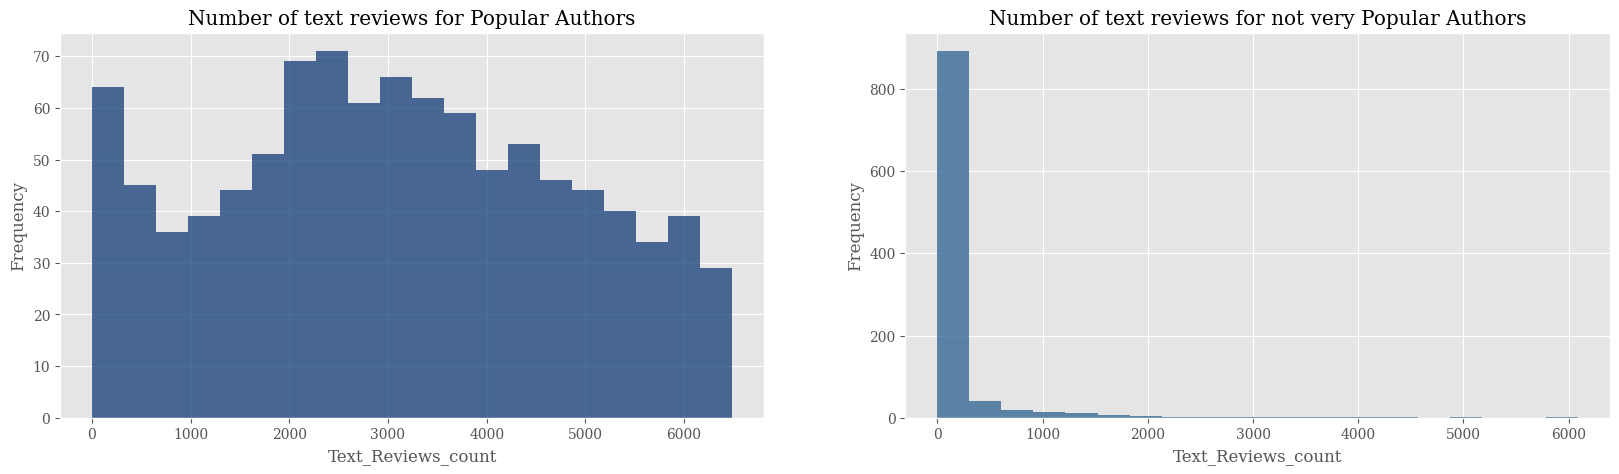

In [ ]:
best_1000 = filtered_fans_and_reviews.head(1000) #Because the data is already ordered
remaining_rows = filtered_fans_and_reviews.drop(best_1000.index)
others_1000 = remaining_rows.sample(n=1000, random_state=42)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
axes[0].hist(best_1000["text_reviews_count"], bins=20, alpha=0.8, label='best', color = our_colors[0])
axes[0].set_title("Number of text reviews for Popular Authors")
axes[0].set_xlabel("Text_Reviews_count")
axes[0].set_ylabel('Frequency')

# Plot per la distribuzione dei dati del gruppo "non-eng"
axes[1].hist(others_1000["text_reviews_count"], bins=20, alpha=0.8, label='other_authors', color = our_colors[2])
axes[1].set_title("Number of text reviews for not very Popular Authors")
axes[1].set_xlabel("Text_Reviews_count")
axes[1].set_ylabel('Frequency')

# Well the distributions are very different, what about their means? Let's do the test.

We then do the test to compare the averages of the two groups, the standard test method has as the null hypothesis <br> 
H0 that there is no significant difference between the number of reviews ("text_reviews_count") between the "best_1000" group and the "others_1000" group <br>
while the alternative hypothesis <br> H1 is there is a significant difference between the number of reviews ("text_reviews_count") in the "best_1000" and "others_1000" groups" 
<br>
but it does not specify in which direction. It may be higher or lower.

In [ ]:
statistic, p_value = mannwhitneyu(best_1000["text_reviews_count"], others_1000["text_reviews_count"], alternative="two-sided")

print("Statistic:", statistic)
print("p-value:", p_value)


Statistic: 967271.0
p-value: 5.829949649923864e-287


We then do the twosided test and have that our hypothesis are: <br>
H0: There is no significant difference between the number of reviews ("text_reviews_count") between the group "best_1000" and the group "others_1000" <br>
H1: The number of reviews ("text_reviews_count") in the "best_1000" group is significantly greater than the number of reviews in the "others_1000" group. 

In [ ]:
statistic, p_value = mannwhitneyu(best_1000["text_reviews_count"], others_1000["text_reviews_count"], alternative="greater")
print("Statistic:", statistic)
print("p-value:", p_value)

Statistic: 967271.0
p-value: 2.914974824961932e-287


In both tests the p-value is very small so we reject the null hypotheses and accept the alternative, there is then a difference between the two groups and we can now conclude that the number of reviews for authors who have more fans is greater than the number of reviews for authors who have fewer fans.

- Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

1) First we can ask ourselves, why use hypothesis tests? <br>
for example, when a statistician needs to make an estimate of a population parameter one starts by sampling a representative sample of the population, but once the parameter estimate (statistic) is obtained, how can one prove whether this parameter corresponds to the true parameter of the population that is, however, unknown? <br>
It will be necessary to make some assumptions and run the so-called hypothesis tests, so hypothesis testing is a statistical procedure that allows us to ask a question based on sample information in order to reach a statistically significant decision. <br>
The idea is that it always exists a situation which can be considered as the default, it is the null hypothesis H0. <br>
On the other hand, there is the alternative scenario, that, if accepted, will change the status: the Alternative Hypothesis H1 <br>
The goal is to assess whether the evidence from the sample provides enough support to reject the null hypothesis in favor of the alternative hypothesis. <br>

2) How to choose the hypothesis? <br>
The null hypothesis H0 is the one best accepted when you are unsure of your assumptions while the alternative hypothesis totally changes the scenario. <br>
In order to choose one's assumptions, it is necessary to introduce two main types of errors, the error of the first kind and the error of the second kind:
- Type I error, that is, mistakenly rejecting the null hypothesis, which was true, by accepting the alternative hypothesis. This error is also denoted by $\alpha$.
- Type II error, accepting the null hypothesis as valid, when it should have been rejected as false. This type of error is instead indicated with $\beta$. <br>
The error of the first type is the one considered the most important and therefore an attempt is made to minimize it. <br>
Typically $\alpha$ takes values of 0.05 i.e., the probability of wrongly rejecting the null hypothesis is 5% . The level of alpha also corresponds to the reliability of the test because the degree of confidence intervals is 1-$\alpha$ and thus is usually 95%. <br>
The 1-$\beta$ quantity, on the other hand, is known as the power of the test. <br>
Of course, the goal is to have as small errors as possible, but for the same sample size as alpha decreases the value of beta increases, so it is a trade-off between these two quantities. <br>

3) Type of hypothesis <br>
At this point we have chosen the test hypotheses and know that there are two types of errors, we have also chosen the alpha significance level. <br>
We then obtain the region of acceptance the region of rejection, calculate the test statistic and check whether its value falls within the region of acceptance or rejection. <br>
Hypothesis tests are being:
- one-sided, that is, when the rejection region consists of only one interval.
- bilateral, that is, when the rejection region consists of two intervals. <br>
Usually to tell whether you have a bilateral or unilateral test you need to look at the shape of the alternative hypothesis, if it contains symbols such as $>$ or $<$ it will be unilateral while with the symbol $\neq$ it is a bilateral test. <br>
Not only do you use the critical values of the test statistics to see whether or not you accept the null hypothesis but you can also use the p-value. If the p-value is less than alpha you reject the null hypothesis and accept the alternative hypothesis.

4) Parametric or not parametric test 
Parametric statistical methods are all methods that are based on probabilistic distributions such as the normal distribution or the student t distribution. <br> 
In contrast, non parametric are those that are not based on any probabilistic distribution. Thus in general, nonparametric tests should be preferred when the data do not distribute according to a normal, or in any case one is unable to prove it, for example, due to numerosity reduced. <br>
In terms of assumptions for making tests we have that
- parametric tests
    1) continuous variables
    2) assumption of normality of the data
    3) equal variance between groups (homoschedasticity)
- nonparametric tests
    1) any type of data
    2) no probabilistic assumptions about the distribution of the data
    3) variances across groups can be different
Parametric tests seem to be fine in any case, why then are they not used all the time? <br>
Because parametric tests are more sensitive and accurate and require smaller samples than nonparametric tests to achieve the same level of significativity.

5) Helpful statistical test <br>
We can make a table to summarize the test.

| **Purpose**                                                                                               | **Parametric test**      | **Non Parametric test**    |
|-----------------------------------------------------------------------------------------------------------|--------------------------|----------------------------|
| Test on a parameter of location (mean or median)                                                          | t-test                   | Wilcoxon Mann Whitney test |
| Determination of linear relationship between two variables                                                | Pearson correlation test | Spearman correlation test  |
| Test the hypothesis that two populations that both follow normal distributions have the same variance     | F-test                   | Kruskal - Wallis test      |
| Evaluate the differences between the averages of multiple groups                                          | ANOVA                    | Kruskal - Wallis test      |
| Determine whether the difference between a sample mean and a population mean is statistically significant | Z-test                   | Wilcoxon Mann Whitney test |

-----------------------------------------------------

# Bonus points

## 1.

### 1.1 Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload authors.json dataset, and filter authors with at least 100 reviews. Do the same using Pandas and compare performance in terms of milliseconds.

Using PySpark to load the `authors.json` dataset and filter authors with at least 100 reviews.

In [ ]:
# start time
start_time = time.time()

# loading dataset
df = spark.read.json('lighter_authors.json')

# filtering authors with at least 100 reviews
filtered_df = df.filter(df.text_reviews_count >= 100)

filtered_df.show()

# end time
end_time = time.time()

# print the execution time
print("Time taken with PySpark: {} ms".format((end_time - start_time)*1000))

+--------------------+--------------+--------------------+----------+------+---+--------------------+--------------------+-------------+------------------+--------------------+-----------+
|               about|average_rating|            book_ids|fans_count|gender| id|           image_url|                name|ratings_count|text_reviews_count|            work_ids|works_count|
+--------------------+--------------+--------------------+----------+------+---+--------------------+--------------------+-------------+------------------+--------------------+-----------+
|Douglas Noël Adam...|          4.19|[386162, 13, 8695...|     19826|  male|  4|https://images.gr...|       Douglas Adams|      2862064|             62681|[3078186, 135328,...|        106|
|William McGuire "...|          4.02|[9791, 21, 28, 24...|     16144|  male|  7|https://images.gr...|         Bill Bryson|      1417316|             84176|[613469, 2305997,...|         75|
|Jude Fisher is th...|          4.53|[349254, 15222, 1.

Using Pandas to load the `authors.json` dataset and filter authors with at least 100 reviews.

In [ ]:
# start time
start_time = time.time()

# loading dataset
df = pd.read_json('lighter_authors.json' , lines=True)

# filtering authors with at least 100 reviews
filtered_df = df[df['text_reviews_count'] >= 100]

print(filtered_df)

# end time
end_time = time.time()

# print the execution time
print("Time taken with pandas: {} ms".format((end_time - start_time)*1000))

        ratings_count  average_rating  text_reviews_count  \
0             2862064            4.19               62681   
1             1417316            4.02               84176   
2               56159            4.53                 352   
3                3302            3.79                 480   
4                7979            3.60                 772   
...               ...             ...                 ...   
351702           1033            4.13                 203   
351711           1280            4.14                 101   
351712           1604            4.13                 191   
351724            216            4.16                 123   
351736           2972            3.28                 639   

                                                 work_ids  \
0       [3078186, 135328, 1877624, 74123, 3078120, 104...   
1       [613469, 2305997, 940892, 2611786, 7800569, 31...   
2       [17150, 808427, 20487307, 90550, 25460625, 171...   
3       [4417, 14300808

#### Comparing the performance of the two approaches:
PySpark is faster than Pandas. The difference is more evident when the dataset is larger. This is because PySpark is a distributed computing framework, while Pandas is a single-node library.

------------------------------------------------------------

### 1.2 Select one alternative library to Pandas (i.e., Dask, Polar, Vaex, Datatable, etc.), upload books.json, and join them with authors.json based on author_id. How many books don’t have a match for the author?

In [ ]:
# Load the data into pyspark dataframes
df_lighter_books = spark.read.json("lighter_books.json")
df_lighter_authors = spark.read.json("lighter_authors.json")

In [ ]:
# Perform the join operation
joined_df = df_lighter_books.join(df_lighter_authors, df_lighter_books.author_id == df_lighter_authors.id, 'left_outer')

In [ ]:
# Count the number of books without a matching author
books_without_author = joined_df.filter(df_lighter_authors.id.isNull()).count()

In [ ]:
# Print the result
print("Number of books without a matching author:", books_without_author)

Number of books without a matching author: 0


#### Conclusion:
The number of books that don't have a match for the author is `0`.

-------------------------------------------------------

## 2. Every book should have a field named description, and any author should have a field named description. Choose one of the two and perform a text-mining analysis:

### 2.1 If you choose to text-mine books.json ’ descriptions, try to find a way to group books in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [ ]:
# select "title" and "description" columns from df_lighter_books
df_lighter_books = df_lighter_books.select("title", "description")

In [ ]:
# perform data cleaning and preprocessing on the "description" column
df_lighter_books = df_lighter_books.filter(trim(col('description')) != '') # removes rows with empty description
df_lighter_books = df_lighter_books.dropna(subset=['description']) # removes rows with null values in description
df_lighter_books = df_lighter_books.withColumn('description', regexp_replace('description', '<.*?>', '')) # remove html tags
df_lighter_books = df_lighter_books.withColumn('description', regexp_replace('description', '[^\sa-zA-Z0-9]', '')) # remove special characters
df_lighter_books = df_lighter_books.withColumn('description', regexp_replace('description', '\s+', ' ')) # remove extra spaces
df_lighter_books = df_lighter_books.withColumn('description', regexp_replace('description', '^\s+|\s+$', '')) # remove leading and trailing spaces
df_lighter_books = df_lighter_books.withColumn('description', lower(col('description'))) # convert to lowercase

In [ ]:
# perform data cleaning and preprocessing on the "title" column
df_lighter_books = df_lighter_books.filter(trim(col('title')) != '') # removes rows with empty title
df_lighter_books = df_lighter_books.dropna(subset=['title']) # removes rows with null values in title
df_lighter_books = df_lighter_books.withColumn('title', regexp_replace('title', '<.*?>', '')) # remove html tags
df_lighter_books = df_lighter_books.withColumn('title', regexp_replace('title', '[^\sa-zA-Z0-9]', '')) # remove special characters
df_lighter_books = df_lighter_books.withColumn('title', regexp_replace('title', '\s+', ' ')) # remove extra spaces
df_lighter_books = df_lighter_books.withColumn('title', regexp_replace('title', '^\s+|\s+$', '')) # remove leading and trailing spaces
df_lighter_books = df_lighter_books.withColumn('title', lower(col('title'))) # convert to lowercase

In [ ]:
# summary statistics of the dataframe
df_lighter_books.describe().show()

+-------+--------+--------------------+
|summary|   title|         description|
+-------+--------+--------------------+
|  count| 5462026|             5462026|
|   mean|     NaN|9.077326391804685...|
| stddev|     NaN|            Infinity|
|    min|        |                    |
|    max|zzzzzzzz|zzzziiiinnngggg s...|
+-------+--------+--------------------+



We aim to group authors based on genres derived from the "description" field of our DataFrame, `df_lighter_books`. To accomplish this, we use the PySpark machine learning library to process the text and apply K-means clustering, an unsupervised learning algorithm.

#### Methodology

We implemented the following steps in a PySpark pipeline:

1. **Tokenization**: We used PySpark's `Tokenizer` to divide the text into individual words, resulting in a column of arrays containing tokenized words.

2. **Stopwords Removal**: We used `StopWordsRemover` to remove common words that typically don't carry much meaning (like "and", "the", "a").

3. **Count Vectorization**: We converted our collections of text documents into vectors of token counts using `CountVectorizer`.

4. **TF-IDF Transformation**: We used `IDF` to calculate the Inverse Document Frequency, thereby weighing the importance of words across the documents.

5. **K-means Clustering**: Finally, we applied the K-means algorithm, which grouped authors into clusters (or genres) based on the TF-IDF features of their descriptions.

#### Results

We fit our pipeline model on `df_lighter_books` and then transformed the DataFrame to get genre predictions. We set the number of clusters (K) to 5, although this parameter could be adjusted to refine the grouping.

After fitting the model, we extracted the cluster centers and identified the top 10 words associated with each cluster, which helped us interpret the characteristics of each cluster.

In [ ]:
# Tokenization
tokenizer = Tokenizer(inputCol="description", outputCol="words")
# Remove stop words and special characters
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Count Vectorization
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
# TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")
# K-means clustering
kmeans = KMeans(k=5, seed=55, featuresCol="features", predictionCol="genre")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, countVectorizer, idf, kmeans])

# Fit the pipeline model
model = pipeline.fit(df_lighter_books)

# Transform the DataFrame to get genre predictions
df_with_predictions_books = model.transform(df_lighter_books)

# Show the cluster centers
print("Cluster Centers:")
centers = model.stages[-1].clusterCenters()
for center in centers:
    print(center)

Cluster Centers:
[5.69728917e-01 1.96845942e-01 2.50925284e-01 ... 2.72271368e-05
 2.37798960e-05 7.35027829e-05]
[1.45876464e-01 4.53179969e-02 6.52285010e-03 ... 0.00000000e+00
 0.00000000e+00 1.34158252e-04]
[2.67832293e+01 1.50080913e+01 9.37211361e-03 ... 5.17010205e-05
 0.00000000e+00 0.00000000e+00]
[2.27606590e-01 9.79674109e+00 5.05809907e-03 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[8.37373816e-02 4.00035056e-02 1.03214131e+00 ... 2.71842266e-04
 2.85623082e-04 1.83927173e-04]


In [ ]:
# Show books with their corresponding genre predictions
df_with_predictions_books.select("title", "genre").show()

+--------------------+-----+
|               title|genre|
+--------------------+-----+
|harry potter and ...|    0|
|harry potter and ...|    4|
|harry potter and ...|    0|
|harry potter and ...|    0|
|harry potter and ...|    0|
|the harry potter ...|    0|
|harry potter boxe...|    0|
|harry potter coll...|    0|
|the hitchhikers g...|    0|
|the ultimate hitc...|    4|
|the ultimate hitc...|    4|
|the hitchhikers g...|    0|
|the hitchhikers g...|    4|
|the hitchhikers g...|    0|
|the ultimate hitc...|    4|
|the hitchhikers g...|    0|
|a short history o...|    4|
|bill brysons afri...|    4|
|brysons dictionar...|    0|
|in a sunburned co...|    4|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Extract the vocabulary from CountVectorizer
vocabulary = model.stages[2].vocabulary

# Get the top N words from each cluster
N = 10  # Number of words per cluster
for i, center in enumerate(centers):
    topN = center.argsort()[-N:][::-1]
    print(f"Cluster {i}:")
    for idx in topN:
        print(vocabulary[idx])

Cluster 0:
de
book
work
en
e
one
new
o
life
world
Cluster 1:
und
der
die
sie
von
zu
ist
den
das
sich
Cluster 2:
de
la
que
y
en
el
et
un
le
les
Cluster 3:
di
e
che
il
la
un
per
una
della
del
Cluster 4:
life
one
new
book
world
love
time
first
story
years


In [ ]:
df_with_predictions_books.describe().show() # summary statistics of the dataframe

+-------+--------+--------------------+------------------+
|summary|   title|         description|             genre|
+-------+--------+--------------------+------------------+
|  count| 5462026|             5462026|           5462026|
|   mean|     NaN|9.077326391804685...|1.3543538606370604|
| stddev|     NaN|            Infinity|1.8233677125034415|
|    min|        |                    |                 0|
|    max|zzzzzzzz|zzzziiiinnngggg s...|                 4|
+-------+--------+--------------------+------------------+



#### Conclusion

Using PySpark's machine learning pipeline, we were able to group authors into genres based on their descriptions. This approach could be further refined by tuning the parameters of the K-means model or experimenting with other text processing techniques and clustering algorithms.

-------------------------------------------------------

### 2.2 If you choose to text-mine authors.json’ about-field, try to find a way to group authors in genres using whatever procedure you want, highlighting words that are triggers for these choices.

In [ ]:
# perform data cleaning and preprocessing on the "about" column of df_lighter_authors
df_lighter_authors = df_lighter_authors.filter(trim(col('about')) != '') # removes rows with empty about
df_lighter_authors = df_lighter_authors.dropna(subset=['about']) # removes rows with null values in about
df_lighter_authors = df_lighter_authors.withColumn('about', regexp_replace('about', '<.*?>', '')) # remove html tags
df_lighter_authors = df_lighter_authors.withColumn('about', regexp_replace('about', '[^\sa-zA-Z0-9]', '')) # remove special characters
df_lighter_authors = df_lighter_authors.withColumn('about', regexp_replace('about', '\s+', ' ')) # remove extra spaces
df_lighter_authors = df_lighter_authors.withColumn('about', regexp_replace('about', '^\s+|\s+$', '')) # remove leading and trailing spaces
df_lighter_authors = df_lighter_authors.withColumn('about', lower(col('about'))) # convert to lowercase

In [ ]:
# summary statistics of the dataframe
df_lighter_authors.describe().show()

+-------+--------------------+------------------+------------------+---------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|summary|               about|    average_rating|        fans_count|   gender|                id|           image_url|               name|    ratings_count|text_reviews_count|       works_count|
+-------+--------------------+------------------+------------------+---------+------------------+--------------------+-------------------+-----------------+------------------+------------------+
|  count|              351767|            351767|            351767|   351767|            351767|              351767|             351767|           351767|            351767|            351767|
|   mean|3.465256873439093...| 3.651194313281242|111.61573143586521|     NULL|7751861.1911975825|                NULL|           Infinity|4770.586308550831| 330.9932426862099|25.937137366495435|
| stddev|2.63928850561883

We demonstrate a methodology for grouping authors into genres based on the "about" field, using the PySpark machine learning library. We implement a pipeline consisting of text processing, TF-IDF transformation, and K-means clustering.

#### Methodology

We then proceed with the following steps in our pipeline:

1. **Tokenization**: We divide the text into individual words using PySpark's `Tokenizer`.

2. **Stopwords Removal**: We remove common words that typically don't carry much meaning using `StopWordsRemover`.

3. **Count Vectorization**: We convert our collection of text documents into vectors of token counts using `CountVectorizer`.

4. **TF-IDF Transformation**: We calculate the Inverse Document Frequency to weigh the importance of words across the documents using `IDF`.

5. **K-means Clustering**: We group authors into clusters (or genres) based on the TF-IDF features of their "about" text using K-means.

#### Results

After fitting the model, we extract the cluster centers, which represent the centroid of each cluster in the feature space. We also identify the top 10 words associated with each cluster, which give us an insight into the characteristics of each cluster. The authors, along with their corresponding genre predictions, are then displayed.

In [ ]:
# Tokenization
tokenizer = Tokenizer(inputCol="about", outputCol="words")
# Remove stop words and special characters
remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
# Count Vectorization
countVectorizer = CountVectorizer(inputCol="filtered_words", outputCol="raw_features")
# TF-IDF
idf = IDF(inputCol="raw_features", outputCol="features")
# K-means clustering
kmeans = KMeans(k=5, seed=55, featuresCol="features", predictionCol="genre")

# Create a pipeline
pipeline = Pipeline(stages=[tokenizer, remover, countVectorizer, idf, kmeans])

# Fit the pipeline model
model = pipeline.fit(df_lighter_authors)

# Transform the DataFrame to get genre predictions
df_with_predictions_authors = model.transform(df_lighter_authors)

# Show the cluster centers
print("Cluster Centers:")
centers = model.stages[-1].clusterCenters()
for center in centers:
    print(center)

Cluster Centers:
[0.28937787 0.35162207 0.2722106  ... 0.         0.         0.        ]
[6.87610163e+01 3.51104812e-02 4.41389590e-02 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[2.69259078e+01 2.26954022e-02 3.72203737e-02 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[3.76836256e+01 3.71893913e-02 3.31042193e-02 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[1.92529479e-01 1.35175495e+00 1.68329403e+00 ... 3.67301745e-04
 3.67301745e-04 3.67301745e-04]


In [ ]:
# Show authors with their corresponding genre predictions
df_with_predictions_authors.select("name", "genre").show()

+--------------------+-----+
|                name|genre|
+--------------------+-----+
|       Douglas Adams|    4|
|         Bill Bryson|    4|
|         Jude Fisher|    0|
|James Hamilton-Pa...|    0|
|         Mark Watson|    0|
|       Edith Wharton|    4|
|       Luther Butler|    4|
|        Gary Paulsen|    0|
|           Dale Peck|    0|
|       Angela Knight|    4|
|       Delia Sherman|    0|
|Patricia A. McKillip|    4|
|      Anne McCaffrey|    4|
|Zilpha Keatley Sn...|    0|
|        Kate Horsley|    4|
|   Elaine Cunningham|    0|
|       Philippa Carr|    0|
|     Edward P. Jones|    0|
|        Satyajit Das|    0|
|         Mark Smylie|    4|
+--------------------+-----+
only showing top 20 rows



In [ ]:
# Extract the vocabulary from CountVectorizer
vocabulary = model.stages[2].vocabulary

# Get the top N words from each cluster
N = 10  # Number of words per cluster
for i, center in enumerate(centers):
    topN = center.argsort()[-N:][::-1]
    print(f"Cluster {i}:")
    for idx in topN:
        print(vocabulary[idx])

Cluster 0:
author
writing
university
books
de
lives
book
new
one
also
Cluster 1:
de
en
y
la
el
que
del
su
con
por
Cluster 2:
de
e
en
la
y
em
da
el
o
que
Cluster 3:
de
et
la
le
en
des
il
les
du
dans
Cluster 4:
book
writing
first
years
new
university
also
books
life
published


In [ ]:
df_with_predictions_authors.describe().show() # summary statistics of the dataframe

+-------+--------------------+------------------+------------------+---------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+
|summary|               about|    average_rating|        fans_count|   gender|                id|           image_url|               name|    ratings_count|text_reviews_count|       works_count|             genre|
+-------+--------------------+------------------+------------------+---------+------------------+--------------------+-------------------+-----------------+------------------+------------------+------------------+
|  count|              351767|            351767|            351767|   351767|            351767|              351767|             351767|           351767|            351767|            351767|            351767|
|   mean|3.465256873439093...| 3.651194313281242|111.61573143586521|     NULL|7751861.1911975825|                NULL|           Infinity|4770.5

#### Conclusion

Grouping authors into genres based on their "about" text provides valuable insights into their writing styles and thematic interests. The K-means algorithm, combined with PySpark's text processing, proves useful for this task. Future refinements could include parameter tuning, experimenting with different clustering algorithms, or using additional text processing techniques.

-------------------------------------------------------

### 2.3 If you feel comfortable and did both tasks, analyze the matching of the two procedures. You grouped books and authors in genres. Do these two procedures show correspondence?

As per our high-level analysis, the degree of match between the two procedures would depend on several factors, including the quality and specificity of the `description` and `about` fields, the granularity of the genres (i.e., the number of clusters), and the relevance of the `description` and `about` fields to the actual genres.
Since these fields contain a lot of noise or irrelevant information, and the genres are too granular, the match will be less precise.
Therefore, the correspondence between these two procedures may be lower than expected due to noise in the data and the granularity of the genres.

--------------------------------------------------